In [66]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

In [2]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Append results
            results.append({
                'Year': year,
                'Business Line': business_line,
                'Event Type': event_type,
                'Total Net Loss': total_net_loss,
                'Total Event Count': total_event_count,
                'VaR Net Loss (99.9%)': var_net_loss,
                'VaR Event Count (99.9%)': var_event_count
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line         Event Type  Total Net Loss  \
0    2021     Private Banking     System Failure    39997.063302   
1    2021     Private Banking        Market Risk   -25015.277959   
2    2021     Private Banking              Theft    42115.175841   
3    2021     Private Banking   Natural Disaster    39218.330902   
4    2021     Private Banking              Fraud    24121.482982   
..    ...                 ...                ...             ...   
395  2024  Financial Advisory              Fraud     9214.684790   
396  2024  Financial Advisory  Operational Error     2786.552052   
397  2024  Financial Advisory     System Failure   -22035.975620   
398  2024  Financial Advisory       Cyber Attack    18746.781509   
399  2024  Financial Advisory              Theft    34085.603462   

     Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0                   17          1.647361e+18                   31.000  
1                   20          5.73159

In [3]:
results_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,39997.063302,17,1.647361e+18,31.000
1,2021,Private Banking,Market Risk,-25015.277959,20,5.731591e+18,35.000
2,2021,Private Banking,Theft,42115.175841,23,8.214450e+16,39.000
3,2021,Private Banking,Natural Disaster,39218.330902,24,5.745752e+17,41.000
4,2021,Private Banking,Fraud,24121.482982,23,9.953865e+18,39.000
...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,9214.684790,27,2.909752e+17,43.000
396,2024,Financial Advisory,Operational Error,2786.552052,27,2.402139e+16,43.001
397,2024,Financial Advisory,System Failure,-22035.975620,26,6.821571e+19,44.000
398,2024,Financial Advisory,Cyber Attack,18746.781509,27,5.674946e+05,44.001


In [48]:
#increased by 10% 15% frequency and netloss
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss and Event Count at baseline, +10%, and +15%
            for adjustment, factor in [('Baseline', 1.0), ('+10%', 1.1), ('+15%', 1.15)]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


      Year       Business Line      Event Type Adjustment  Total Net Loss  \
0     2021     Private Banking  System Failure   Baseline    39997.063302   
1     2021     Private Banking  System Failure       +10%    43996.769632   
2     2021     Private Banking  System Failure       +15%    45996.622797   
3     2021     Private Banking     Market Risk   Baseline   -25015.277959   
4     2021     Private Banking     Market Risk       +10%   -27516.805755   
...    ...                 ...             ...        ...             ...   
1195  2024  Financial Advisory    Cyber Attack       +10%    20621.459660   
1196  2024  Financial Advisory    Cyber Attack       +15%    21558.798736   
1197  2024  Financial Advisory           Theft   Baseline    34085.603462   
1198  2024  Financial Advisory           Theft       +10%    37494.163808   
1199  2024  Financial Advisory           Theft       +15%    39198.443981   

      Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0 

In [49]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.00,9.617848e+17,32.000
1,2021,Private Banking,System Failure,+10%,43996.769632,18.70,3.947359e+18,34.000
2,2021,Private Banking,System Failure,+15%,45996.622797,19.55,4.613004e+18,35.000
3,2021,Private Banking,Market Risk,Baseline,-25015.277959,20.00,8.459957e+18,35.001
4,2021,Private Banking,Market Risk,+10%,-27516.805755,22.00,5.879106e+19,38.000
...,...,...,...,...,...,...,...,...
1195,2024,Financial Advisory,Cyber Attack,+10%,20621.459660,29.70,6.485107e+05,48.001
1196,2024,Financial Advisory,Cyber Attack,+15%,21558.798736,31.05,7.414003e+05,48.001
1197,2024,Financial Advisory,Theft,Baseline,34085.603462,19.00,9.409352e+16,34.001
1198,2024,Financial Advisory,Theft,+10%,37494.163808,20.90,4.071274e+17,36.000


In [78]:
#increase one line 
#increased by 10% 15% frequency and netloss
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss and Event Count at baseline, +10%, and +15%
            for adjustment, factor in [('Baseline', 1.0), ('+10%', 1.1)]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year      Business Line            Event Type Adjustment  Total Net Loss  \
0    2021  Wealth Management          Cyber Attack   Baseline   -18864.582375   
1    2021  Wealth Management          Cyber Attack       +10%   -20751.040612   
2    2021  Wealth Management      Natural Disaster   Baseline    10773.786276   
3    2021  Wealth Management      Natural Disaster       +10%    11851.164904   
4    2021  Wealth Management                 Fraud   Baseline    13665.088526   
..    ...                ...                   ...        ...             ...   
795  2024   Asset Management  Regulatory Violation       +10%    37396.513442   
796  2024   Asset Management     Operational Error   Baseline   -30817.209782   
797  2024   Asset Management     Operational Error       +10%   -33898.930761   
798  2024   Asset Management          Cyber Attack   Baseline     2333.810796   
799  2024   Asset Management          Cyber Attack       +10%     2567.191875   

     Total Event Count  VaR

In [79]:
results_df #whole data incraed by 10 %

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Wealth Management,Cyber Attack,Baseline,-18864.582375,27.0,1.593737e+17,46.000
1,2021,Wealth Management,Cyber Attack,+10%,-20751.040612,29.7,4.154701e+17,47.000
2,2021,Wealth Management,Natural Disaster,Baseline,10773.786276,27.0,3.750481e+17,43.001
3,2021,Wealth Management,Natural Disaster,+10%,11851.164904,29.7,2.310260e+17,46.001
4,2021,Wealth Management,Fraud,Baseline,13665.088526,24.0,1.043050e+17,40.000
...,...,...,...,...,...,...,...,...
795,2024,Asset Management,Regulatory Violation,+10%,37396.513442,26.4,7.961142e+16,44.000
796,2024,Asset Management,Operational Error,Baseline,-30817.209782,30.0,5.442387e+15,48.000
797,2024,Asset Management,Operational Error,+10%,-33898.930761,33.0,2.154444e+16,52.000
798,2024,Asset Management,Cyber Attack,Baseline,2333.810796,19.0,4.210227e+18,34.000


In [84]:
#only spefic biusiness line
#only selected event types increased
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Cyber Attack', 'Fraud']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1)
                    #('+15%', 1.15),
                    #('+20%', 1.2),
                    #('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year      Business Line            Event Type Adjustment  Total Net Loss  \
0    2021  Wealth Management          Cyber Attack   Baseline   -18864.582375   
1    2021  Wealth Management          Cyber Attack       +10%   -20751.040612   
2    2021  Wealth Management      Natural Disaster   Baseline    10773.786276   
3    2021  Wealth Management                 Fraud   Baseline    13665.088526   
4    2021  Wealth Management                 Fraud       +10%    15031.597379   
..    ...                ...                   ...        ...             ...   
475  2024   Asset Management            Compliance   Baseline    -1418.200707   
476  2024   Asset Management  Regulatory Violation   Baseline    33996.830402   
477  2024   Asset Management     Operational Error   Baseline   -30817.209782   
478  2024   Asset Management          Cyber Attack   Baseline     2333.810796   
479  2024   Asset Management          Cyber Attack       +10%     2567.191875   

     Total Event Count  VaR

In [85]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Wealth Management,Cyber Attack,Baseline,-18864.582375,27.0,1.845188e+17,45.000
1,2021,Wealth Management,Cyber Attack,+10%,-20751.040612,29.7,3.329660e+17,48.000
2,2021,Wealth Management,Natural Disaster,Baseline,10773.786276,27.0,9.699594e+17,45.000
3,2021,Wealth Management,Fraud,Baseline,13665.088526,24.0,1.769805e+17,41.000
4,2021,Wealth Management,Fraud,+10%,15031.597379,26.4,9.567517e+16,44.000
...,...,...,...,...,...,...,...,...
475,2024,Asset Management,Compliance,Baseline,-1418.200707,26.0,1.433243e+17,44.000
476,2024,Asset Management,Regulatory Violation,Baseline,33996.830402,24.0,2.013585e+16,40.000
477,2024,Asset Management,Operational Error,Baseline,-30817.209782,30.0,1.093855e+16,49.000
478,2024,Asset Management,Cyber Attack,Baseline,2333.810796,19.0,4.089637e+19,34.000


In [86]:
results_df['Event Type'].value_counts()

Event Type
Cyber Attack            80
Fraud                   80
Natural Disaster        40
Market Risk             40
System Failure          40
Regulatory Violation    40
Vendor Risk             40
Compliance              40
Theft                   40
Operational Error       40
Name: count, dtype: int64

In [88]:
#add quarter
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines and event types
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines
event_types_to_adjust = ['Cyber Attack', 'Fraud']  # Replace with desired event types

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            if business_line not in selected_business_lines:
                continue  # Skip non-selected business lines
            
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Default adjustment (no increase) for non-selected event types
                adjustments = [('Baseline', 1.0)]
                
                # Apply adjustments only for selected event types
                if event_type in event_types_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1)
                        #('+15%', 1.15),
                        #('+20%', 1.2),
                        #('+25%', 1.25)
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3529551991.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Corporate Banking - Natural Disaster in 2021 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3529551991.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Corporate Banking - Cyber Attack in 2022 Q1. Skipping.
No positive losses for Corporate Banking - Market Risk in 2022 Q2. Skipping.
No positive losses for Corporate Banking - Cyber Attack in 2022 Q3. Skipping.
No positive losses for Corporate Banking - Operational Error in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3529551991.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Corporate Banking - System Failure in 2023 Q2. Skipping.
No positive losses for Corporate Banking - Fraud in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3529551991.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Corporate Banking - Market Risk in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Corporate Banking - Cyber Attack in 2024 Q4. Skipping.
     Year  Quarter      Business Line            Event Type Adjustment  \
0    2021        1  Corporate Banking           Vendor Risk   Baseline   
1    2021        1  Corporate Banking                 Fraud   Baseline   
2    2021        1  Corporate Banking                 Fraud       +10%   
3    2021        1  Corporate Banking          Cyber Attack   Baseline   
4    2021        1  Corporate Banking          Cyber Attack       +10%   
..    ...      ...                ...                   ...        ...   
174  2024        4  Corporate Banking  Regulatory Violation   Baseline   
175  2024        4  Corporate Banking                 Fraud   Baseline   
176  2024        4  Corporate Banking                 Fraud       +10%   
177  2024        4  Corporate Banking            Compliance   Baseline   
178  2024        4  Corporate Banking           Vendor Risk   Baseline   

     Total Net Loss  Total Event 

In [89]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Corporate Banking,Vendor Risk,Baseline,-681.829311,9.0,3.132543e+21,19.000
1,2021,1,Corporate Banking,Fraud,Baseline,-13076.187836,5.0,1.788231e+20,13.000
2,2021,1,Corporate Banking,Fraud,+10%,-14383.806619,5.5,3.413037e+20,14.000
3,2021,1,Corporate Banking,Cyber Attack,Baseline,3576.745951,5.0,7.730574e+20,14.000
4,2021,1,Corporate Banking,Cyber Attack,+10%,3934.420546,5.5,1.934152e+20,14.000
...,...,...,...,...,...,...,...,...,...
174,2024,4,Corporate Banking,Regulatory Violation,Baseline,29605.694852,11.0,5.424651e+18,22.001
175,2024,4,Corporate Banking,Fraud,Baseline,-5408.279273,6.0,6.635541e+20,15.000
176,2024,4,Corporate Banking,Fraud,+10%,-5949.107200,6.6,8.279684e+20,16.000
177,2024,4,Corporate Banking,Compliance,Baseline,-13435.569328,4.0,2.693946e+03,11.000


In [5]:
results_df

,Prediction Year,Business Line,Event Type,Average Net Loss (2021–2024),Average Event Count (2021–2024),VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2025,Corporate Banking,Compliance,-44511.931610,25.50,670918.025486,42.0
1,2025,Corporate Banking,Vendor Risk,-13183.467978,24.00,446507.595435,41.0
2,2025,Corporate Banking,Theft,22323.587859,25.50,451962.135767,41.0
3,2025,Corporate Banking,Operational Error,26282.011363,24.50,437573.914228,42.0
4,2025,Corporate Banking,System Failure,-4787.022903,24.00,401506.314425,40.0
...,...,...,...,...,...,...,...
95,2025,Insurance,Market Risk,-17561.154709,24.25,407548.011490,40.0
96,2025,Insurance,Cyber Attack,15736.879016,22.00,371767.705648,38.0
97,2025,Insurance,Natural Disaster,-17518.441928,29.75,537249.941666,47.0
98,2025,Insurance,Regulatory Violation,-17430.764354,25.25,518196.528886,42.0


In [90]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines

# Define event types and their adjustment factors
event_type_adjustments = {
    'Cyber Attack': 1.10,  # Increase by 10%
    'Fraud': 1.15,         # Increase by 15%
    'Operational Failure': 1.25  # Increase by 25%
}

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            if business_line not in selected_business_lines:
                continue  # Skip non-selected business lines
            
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Default adjustment (no increase) for baseline
                adjustments = [('Baseline', 1.0)]
                
                # Apply specific adjustments for defined event types
                if event_type in event_type_adjustments:
                    adjustments.append((f"+{int((event_type_adjustments[event_type] - 1) * 100)}%", event_type_adjustments[event_type]))
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3525984631.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Corporate Banking - Natural Disaster in 2021 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3525984631.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Corporate Banking - Cyber Attack in 2022 Q1. Skipping.
No positive losses for Corporate Banking - Market Risk in 2022 Q2. Skipping.
No positive losses for Corporate Banking - Cyber Attack in 2022 Q3. Skipping.
No positive losses for Corporate Banking - Operational Error in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3525984631.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Corporate Banking - System Failure in 2023 Q2. Skipping.
No positive losses for Corporate Banking - Fraud in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3525984631.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Corporate Banking - Market Risk in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Corporate Banking - Cyber Attack in 2024 Q4. Skipping.
     Year  Quarter      Business Line            Event Type Adjustment  \
0    2021        1  Corporate Banking           Vendor Risk   Baseline   
1    2021        1  Corporate Banking                 Fraud   Baseline   
2    2021        1  Corporate Banking                 Fraud       +14%   
3    2021        1  Corporate Banking          Cyber Attack   Baseline   
4    2021        1  Corporate Banking          Cyber Attack       +10%   
..    ...      ...                ...                   ...        ...   
174  2024        4  Corporate Banking  Regulatory Violation   Baseline   
175  2024        4  Corporate Banking                 Fraud   Baseline   
176  2024        4  Corporate Banking                 Fraud       +14%   
177  2024        4  Corporate Banking            Compliance   Baseline   
178  2024        4  Corporate Banking           Vendor Risk   Baseline   

     Total Net Loss  Total Event 

In [91]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Corporate Banking,Vendor Risk,Baseline,-681.829311,9.00,1.745917e+22,19.0
1,2021,1,Corporate Banking,Fraud,Baseline,-13076.187836,5.00,2.676517e+21,13.0
2,2021,1,Corporate Banking,Fraud,+14%,-15037.616011,5.75,1.417151e+20,14.0
3,2021,1,Corporate Banking,Cyber Attack,Baseline,3576.745951,5.00,3.563469e+20,13.0
4,2021,1,Corporate Banking,Cyber Attack,+10%,3934.420546,5.50,1.954174e+22,14.0
...,...,...,...,...,...,...,...,...,...
174,2024,4,Corporate Banking,Regulatory Violation,Baseline,29605.694852,11.00,5.721246e+19,22.0
175,2024,4,Corporate Banking,Fraud,Baseline,-5408.279273,6.00,2.200634e+19,15.0
176,2024,4,Corporate Banking,Fraud,+14%,-6219.521164,6.90,8.504273e+19,16.0
177,2024,4,Corporate Banking,Compliance,Baseline,-13435.569328,4.00,2.693946e+03,11.0


In [92]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines

# Define event types and their adjustment factors
event_type_adjustments = {
    'Cyber Attack': 1.10,  # Increase by 10%
    'Fraud': 1.15,         # Increase by 15%
    'Operational Failure': 1.25  # Increase by 25%
}

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        if business_line not in selected_business_lines:
            continue  # Skip non-selected business lines
        
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for baseline
            adjustments = [('Baseline', 1.0)]
            
            # Apply specific adjustments for defined event types
            if event_type in event_type_adjustments:
                adjustments.append((f"+{int((event_type_adjustments[event_type] - 1) * 100)}%", event_type_adjustments[event_type]))
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Year      Business Line            Event Type Adjustment  Total Net Loss  \
0   2021  Corporate Banking                 Fraud   Baseline    18309.676238   
1   2021  Corporate Banking                 Fraud       +14%    21056.127673   
2   2021  Corporate Banking           Market Risk   Baseline     6164.700807   
3   2021  Corporate Banking           Vendor Risk   Baseline    21265.544102   
4   2021  Corporate Banking                 Theft   Baseline     1761.077648   
5   2021  Corporate Banking      Natural Disaster   Baseline   -37460.914961   
6   2021  Corporate Banking  Regulatory Violation   Baseline   -28220.545312   
7   2021  Corporate Banking            Compliance   Baseline    -3482.633923   
8   2021  Corporate Banking          Cyber Attack   Baseline     8616.757758   
9   2021  Corporate Banking          Cyber Attack       +10%     9478.433534   
10  2021  Corporate Banking        System Failure   Baseline    23912.085425   
11  2021  Corporate Banking     Operatio

In [93]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Corporate Banking,Fraud,Baseline,18309.676238,26.00,3.506446e+05,42.000
1,2021,Corporate Banking,Fraud,+14%,21056.127673,29.90,1.933014e+09,48.001
2,2021,Corporate Banking,Market Risk,Baseline,6164.700807,22.00,4.010627e+16,37.000
3,2021,Corporate Banking,Vendor Risk,Baseline,21265.544102,22.00,3.620874e+05,39.000
4,2021,Corporate Banking,Theft,Baseline,1761.077648,24.00,9.510636e+16,40.000
5,2021,Corporate Banking,Natural Disaster,Baseline,-37460.914961,27.00,1.383119e+20,44.001
6,2021,Corporate Banking,Regulatory Violation,Baseline,-28220.545312,23.00,3.032856e+18,39.001
7,2021,Corporate Banking,Compliance,Baseline,-3482.633923,29.00,1.896504e+17,47.001
8,2021,Corporate Banking,Cyber Attack,Baseline,8616.757758,20.00,3.409948e+18,35.000
9,2021,Corporate Banking,Cyber Attack,+10%,9478.433534,22.00,1.174011e+18,38.000


In [94]:
remove the baseline records

SyntaxError: invalid syntax (2393921706.py, line 1)

In [95]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines

# Define event types and their adjustment factors
event_type_adjustments = {
    'Cyber Attack': 1.10,  # Increase by 10%
    'Fraud': 1.15,         # Increase by 15%
    'Operational Failure': 1.25  # Increase by 25%
}

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        if business_line not in selected_business_lines:
            continue  # Skip non-selected business lines
        
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Initialize adjustments (only include Baseline if not in event_type_adjustments)
            adjustments = []
            if event_type not in event_type_adjustments:
                adjustments.append(('Baseline', 1.0))
            
            # Add defined adjustments for selected event types
            if event_type in event_type_adjustments:
                adjustments.append((f"+{int((event_type_adjustments[event_type] - 1) * 100)}%", event_type_adjustments[event_type]))
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Year      Business Line            Event Type Adjustment  Total Net Loss  \
0   2021  Corporate Banking                 Fraud       +14%    21056.127673   
1   2021  Corporate Banking           Market Risk   Baseline     6164.700807   
2   2021  Corporate Banking           Vendor Risk   Baseline    21265.544102   
3   2021  Corporate Banking                 Theft   Baseline     1761.077648   
4   2021  Corporate Banking      Natural Disaster   Baseline   -37460.914961   
5   2021  Corporate Banking  Regulatory Violation   Baseline   -28220.545312   
6   2021  Corporate Banking            Compliance   Baseline    -3482.633923   
7   2021  Corporate Banking          Cyber Attack       +10%     9478.433534   
8   2021  Corporate Banking        System Failure   Baseline    23912.085425   
9   2021  Corporate Banking     Operational Error   Baseline    23129.669768   
10  2022  Corporate Banking                 Theft   Baseline    14175.393142   
11  2022  Corporate Banking  Regulatory 

In [96]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Corporate Banking,Fraud,+14%,21056.127673,29.90,1.933032e+09,49.000
1,2021,Corporate Banking,Market Risk,Baseline,6164.700807,22.00,1.588472e+16,39.000
2,2021,Corporate Banking,Vendor Risk,Baseline,21265.544102,22.00,3.607400e+05,37.000
3,2021,Corporate Banking,Theft,Baseline,1761.077648,24.00,2.646026e+17,40.000
4,2021,Corporate Banking,Natural Disaster,Baseline,-37460.914961,27.00,8.287298e+20,44.000
5,2021,Corporate Banking,Regulatory Violation,Baseline,-28220.545312,23.00,9.100705e+19,39.000
6,2021,Corporate Banking,Compliance,Baseline,-3482.633923,29.00,3.931135e+17,47.000
7,2021,Corporate Banking,Cyber Attack,+10%,9478.433534,22.00,4.495172e+17,39.000
8,2021,Corporate Banking,System Failure,Baseline,23912.085425,29.00,4.768694e+05,47.000
9,2021,Corporate Banking,Operational Error,Baseline,23129.669768,30.00,5.228901e+05,47.001


In [100]:
#quarterly
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Derive 'Year' and 'Quarter' columns
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines

# Define event types and their adjustment factors
event_type_adjustments = {
    'Cyber Attack': 1.10,  # Increase by 10%
    'Fraud': 1.15,         # Increase by 15%
    'Operational Failure': 1.25  # Increase by 25%
}

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for quarter in range(1, 5):  # Adding quarters
        quarter_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarter_data['Business Line'].unique():
            if business_line not in selected_business_lines:
                continue  # Skip non-selected business lines
            
            bl_data = quarter_data[quarter_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Initialize adjustments (only include Baseline if not in event_type_adjustments)
                adjustments = []
                if event_type not in event_type_adjustments:
                    adjustments.append(('Baseline', 1.0))
                
                # Add defined adjustments for selected event types
                if event_type in event_type_adjustments:
                    adjustments.append((f"+{int((event_type_adjustments[event_type] - 1) * 100)}%", event_type_adjustments[event_type]))
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Corporate Banking - Natural Disaster in 2021 Q4. Skipping.
No positive losses for Corporate Banking - Cyber Attack in 2022 Q1. Skipping.
No positive losses for Corporate Banking - Market Risk in 2022 Q2. Skipping.
No positive losses for Corporate Banking - Cyber Attack in 2022 Q3. Skipping.
No positive losses for Corporate Banking - Operational Error in 2022 Q4. Skipping.
No positive losses for Corporate Banking - System Failure in 2023 Q2. Skipping.
No positive losses for Corporate Banking - Fraud in 2023 Q2. Skipping.
No positive losses for Corporate Banking - Market Risk in 2024 Q3. Skipping.
No positive losses for Corporate Banking - Cyber Attack in 2024 Q4. Skipping.
     Year  Quarter      Business Line            Event Type Adjustment  \
0    2021        1  Corporate Banking           Vendor Risk   Baseline   
1    2021        1  Corporate Banking                 Fraud       +14%   
2    2021        1  Corporate Banking          Cyber Attack       +10%   


In [101]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Corporate Banking,Vendor Risk,Baseline,-681.829311,9.00,2.469759e+21,19.000
1,2021,1,Corporate Banking,Fraud,+14%,-15037.616011,5.75,2.368385e+20,15.000
2,2021,1,Corporate Banking,Cyber Attack,+10%,3934.420546,5.50,1.853447e+21,14.000
3,2021,1,Corporate Banking,Theft,Baseline,19221.019858,7.00,2.578525e+20,16.000
4,2021,1,Corporate Banking,Market Risk,Baseline,434.999537,4.00,1.106893e+21,11.000
...,...,...,...,...,...,...,...,...,...
146,2024,4,Corporate Banking,Operational Error,Baseline,13086.928747,5.00,1.462123e+21,13.001
147,2024,4,Corporate Banking,Regulatory Violation,Baseline,29605.694852,11.00,1.551017e+19,23.000
148,2024,4,Corporate Banking,Fraud,+14%,-6219.521164,6.90,1.825288e+21,16.000
149,2024,4,Corporate Banking,Compliance,Baseline,-13435.569328,4.00,2.938583e+03,11.000


In [98]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define specific business lines
selected_business_lines = ['Retail Banking', 'Corporate Banking']  # Replace with desired business lines

# Define event types and their adjustment factors
event_type_adjustments = {
    'Cyber Attack': 1.10,  # Increase by 10%
    'Fraud': 1.15,         # Increase by 15%
    'Operational Failure': 1.25  # Increase by 25%
}
yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]

    for quarter in range(1, 5):
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]

        for business_line in quarterly_data['Business Line'].unique():
            if business_line not in selected_business_lines:
                continue  # Skip non-selected business lines

            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]

            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]

                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()

                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per year

                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)

                # Initialize adjustments (only include Baseline if not in event_type_adjustments)
                adjustments = []
                if event_type not in event_type_adjustments:
                    adjustments.append(('Baseline', 1.0))

                # Add defined adjustments for selected event types
                if event_type in event_type_adjustments:
                    adjustments.append((f"+{int((event_type_adjustments[event_type] - 1) * 100)}%", event_type_adjustments[event_type]))

                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor

                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )

                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )

                    # Append results
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\116420892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter


KeyError: 'Quarter'

In [ ]:
results_df



In [50]:
#seprate filter from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
baseline_results = []
ten_percent_results = []
fifteen_percent_results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Adjust frequency and severity and calculate VaR for each adjustment
            for adjustment, factor, results_list in [('Baseline', 1.0, baseline_results), 
                                                     ('+10%', 1.1, ten_percent_results),
                                                     ('+15%', 1.15, fifteen_percent_results)]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results to the appropriate list
                results_list.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to separate DataFrames
baseline_df = pd.DataFrame(baseline_results)
ten_percent_df = pd.DataFrame(ten_percent_results)
fifteen_percent_df = pd.DataFrame(fifteen_percent_results)

# Display the separate DataFrames
print("Baseline Results:")
print(baseline_df)
print("\n+10% Results:")
print(ten_percent_df)
print("\n+15% Results:")
print(fifteen_percent_df)


Baseline Results:
     Year       Business Line         Event Type Adjustment  Total Net Loss  \
0    2021     Private Banking     System Failure   Baseline    39997.063302   
1    2021     Private Banking        Market Risk   Baseline   -25015.277959   
2    2021     Private Banking              Theft   Baseline    42115.175841   
3    2021     Private Banking   Natural Disaster   Baseline    39218.330902   
4    2021     Private Banking              Fraud   Baseline    24121.482982   
..    ...                 ...                ...        ...             ...   
395  2024  Financial Advisory              Fraud   Baseline     9214.684790   
396  2024  Financial Advisory  Operational Error   Baseline     2786.552052   
397  2024  Financial Advisory     System Failure   Baseline   -22035.975620   
398  2024  Financial Advisory       Cyber Attack   Baseline    18746.781509   
399  2024  Financial Advisory              Theft   Baseline    34085.603462   

     Total Event Count  VaR Net L

In [52]:
fifteen_percent_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,+15%,45996.622797,19.55,5.419519e+17,35.000
1,2021,Private Banking,Market Risk,+15%,-28767.569653,23.00,3.427278e+19,39.000
2,2021,Private Banking,Theft,+15%,48432.452217,26.45,1.914113e+17,45.000
3,2021,Private Banking,Natural Disaster,+15%,45101.080538,27.60,6.421670e+17,44.000
4,2021,Private Banking,Fraud,+15%,27739.705429,26.45,2.753251e+18,43.000
...,...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,+15%,10596.887508,31.05,4.904042e+17,48.001
396,2024,Financial Advisory,Operational Error,+15%,3204.534860,31.05,3.185577e+16,50.000
397,2024,Financial Advisory,System Failure,+15%,-25341.371963,29.90,3.715224e+18,48.000
398,2024,Financial Advisory,Cyber Attack,+15%,21558.798736,31.05,7.124609e+05,50.000


In [53]:
ten_percent_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,+10%,43996.769632,18.7,9.654402e+17,33.000
1,2021,Private Banking,Market Risk,+10%,-27516.805755,22.0,8.975860e+18,38.000
2,2021,Private Banking,Theft,+10%,46326.693425,25.3,2.556325e+16,42.001
3,2021,Private Banking,Natural Disaster,+10%,43140.163992,26.4,2.361337e+17,44.000
4,2021,Private Banking,Fraud,+10%,26533.631280,25.3,1.702299e+18,42.000
...,...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,+10%,10136.153269,29.7,2.651705e+17,47.001
396,2024,Financial Advisory,Operational Error,+10%,3065.207257,29.7,3.343220e+16,48.000
397,2024,Financial Advisory,System Failure,+10%,-24239.573182,28.6,5.908842e+19,47.000
398,2024,Financial Advisory,Cyber Attack,+10%,20621.459660,29.7,6.680272e+05,47.000


In [54]:
baseline_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.0,3.808296e+18,30.000
1,2021,Private Banking,Market Risk,Baseline,-25015.277959,20.0,9.153871e+18,35.000
2,2021,Private Banking,Theft,Baseline,42115.175841,23.0,5.460993e+16,39.001
3,2021,Private Banking,Natural Disaster,Baseline,39218.330902,24.0,1.916644e+18,40.000
4,2021,Private Banking,Fraud,Baseline,24121.482982,23.0,5.894143e+17,39.000
...,...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,Baseline,9214.684790,27.0,8.645559e+16,44.000
396,2024,Financial Advisory,Operational Error,Baseline,2786.552052,27.0,3.780586e+16,44.000
397,2024,Financial Advisory,System Failure,Baseline,-22035.975620,26.0,3.212502e+18,43.000
398,2024,Financial Advisory,Cyber Attack,Baseline,18746.781509,27.0,5.402991e+05,44.000


In [7]:
results_df #all the lines increased

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.00,1.765464e+18,31.0
1,2021,Private Banking,System Failure,+10%,43996.769632,18.70,1.057429e+19,33.0
2,2021,Private Banking,System Failure,+15%,45996.622797,19.55,3.690147e+18,34.0
3,2021,Private Banking,Market Risk,Baseline,-25015.277959,20.00,3.810936e+18,35.0
4,2021,Private Banking,Market Risk,+10%,-27516.805755,22.00,1.378680e+18,38.0
...,...,...,...,...,...,...,...,...
1195,2024,Financial Advisory,Cyber Attack,+10%,20621.459660,29.70,6.715098e+05,47.0
1196,2024,Financial Advisory,Cyber Attack,+15%,21558.798736,31.05,7.406516e+05,50.0
1197,2024,Financial Advisory,Theft,Baseline,34085.603462,19.00,8.938035e+16,35.0
1198,2024,Financial Advisory,Theft,+10%,37494.163808,20.90,3.387233e+16,37.0


In [33]:
#add quarter from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Add Quarter based on the Date column
            et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Extract quarter from Date
            
            # Append results for each quarter
            for quarter, quarter_data in et_data.groupby('Quarter'):
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Quarter': str(quarter),  # Quarter as string (e.g., '2021Q1')
                    'Total Net Loss': total_net_loss,
                    'Total Event Count': total_event_count,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3635269856.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Extract quarter from Date
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3635269856.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Extract quarter from Date
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3635269856.py:68: SettingWithCopyWarning: 

      Year       Business Line      Event Type Quarter  Total Net Loss  \
0     2021     Private Banking  System Failure  2021Q1    39997.063302   
1     2021     Private Banking  System Failure  2021Q2    39997.063302   
2     2021     Private Banking  System Failure  2021Q3    39997.063302   
3     2021     Private Banking  System Failure  2021Q4    39997.063302   
4     2021     Private Banking     Market Risk  2021Q1   -25015.277959   
...    ...                 ...             ...     ...             ...   
1587  2024  Financial Advisory    Cyber Attack  2024Q4    18746.781509   
1588  2024  Financial Advisory           Theft  2024Q1    34085.603462   
1589  2024  Financial Advisory           Theft  2024Q2    34085.603462   
1590  2024  Financial Advisory           Theft  2024Q3    34085.603462   
1591  2024  Financial Advisory           Theft  2024Q4    34085.603462   

      Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0                    17          1.809

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3635269856.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Extract quarter from Date
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3635269856.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Extract quarter from Date


In [35]:
results_df

,Year,Business Line,Event Type,Quarter,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,2021Q1,39997.063302,17,1.809410e+18,30.0
1,2021,Private Banking,System Failure,2021Q2,39997.063302,17,1.809410e+18,30.0
2,2021,Private Banking,System Failure,2021Q3,39997.063302,17,1.809410e+18,30.0
3,2021,Private Banking,System Failure,2021Q4,39997.063302,17,1.809410e+18,30.0
4,2021,Private Banking,Market Risk,2021Q1,-25015.277959,20,9.431023e+18,35.0
...,...,...,...,...,...,...,...,...
1587,2024,Financial Advisory,Cyber Attack,2024Q4,18746.781509,27,5.369379e+05,44.0
1588,2024,Financial Advisory,Theft,2024Q1,34085.603462,19,4.443848e+17,35.0
1589,2024,Financial Advisory,Theft,2024Q2,34085.603462,19,4.443848e+17,35.0
1590,2024,Financial Advisory,Theft,2024Q3,34085.603462,19,4.443848e+17,35.0


In [8]:
#10-25% yearly
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss and Event Count at baseline and adjusted scenarios
            for adjustment, factor in [
                ('Baseline', 1.0), 
                ('+10%', 1.1), 
                ('+15%', 1.15), 
                ('+20%', 1.2), 
                ('+25%', 1.25)
            ]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


      Year       Business Line      Event Type Adjustment  Total Net Loss  \
0     2021     Private Banking  System Failure   Baseline    39997.063302   
1     2021     Private Banking  System Failure       +10%    43996.769632   
2     2021     Private Banking  System Failure       +15%    45996.622797   
3     2021     Private Banking  System Failure       +20%    47996.475962   
4     2021     Private Banking  System Failure       +25%    49996.329127   
...    ...                 ...             ...        ...             ...   
1995  2024  Financial Advisory           Theft   Baseline    34085.603462   
1996  2024  Financial Advisory           Theft       +10%    37494.163808   
1997  2024  Financial Advisory           Theft       +15%    39198.443981   
1998  2024  Financial Advisory           Theft       +20%    40902.724154   
1999  2024  Financial Advisory           Theft       +25%    42607.004327   

      Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0 

In [9]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.00,1.052023e+19,32.000
1,2021,Private Banking,System Failure,+10%,43996.769632,18.70,3.332926e+18,33.000
2,2021,Private Banking,System Failure,+15%,45996.622797,19.55,4.893145e+19,34.000
3,2021,Private Banking,System Failure,+20%,47996.475962,20.40,1.455602e+18,35.000
4,2021,Private Banking,System Failure,+25%,49996.329127,21.25,3.361897e+18,37.000
...,...,...,...,...,...,...,...,...
1995,2024,Financial Advisory,Theft,Baseline,34085.603462,19.00,8.266185e+17,34.000
1996,2024,Financial Advisory,Theft,+10%,37494.163808,20.90,4.242268e+17,36.000
1997,2024,Financial Advisory,Theft,+15%,39198.443981,21.85,3.732253e+17,37.000
1998,2024,Financial Advisory,Theft,+20%,40902.724154,22.80,1.940632e+17,38.001


In [31]:
#10-25% quarterly  added
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss and Event Count at baseline and adjusted scenarios
            for adjustment, factor in [
                ('Baseline', 1.0), 
                ('+10%', 1.1), 
                ('+15%', 1.15), 
                ('+20%', 1.2), 
                ('+25%', 1.25)
            ]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Add quarter information
                et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Adding quarter based on the Date column
                
                # Append results with quarter info
                for quarter, quarter_data in et_data.groupby('Quarter'):
                    results.append({
                        'Year': year,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Quarter': str(quarter),  # Quarter as string (e.g., '2021Q1')
                        'Adjustment': adjustment,
                        'Adjustment Factor': factor,
                        'Total Net Loss': total_net_loss,
                        'Total Event Count': total_event_count,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\2223843562.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Adding quarter based on the Date column
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\2223843562.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Adding quarter based on the Date column
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\2223843562.py:

      Year       Business Line      Event Type Quarter Adjustment  \
0     2021     Private Banking  System Failure  2021Q1   Baseline   
1     2021     Private Banking  System Failure  2021Q2   Baseline   
2     2021     Private Banking  System Failure  2021Q3   Baseline   
3     2021     Private Banking  System Failure  2021Q4   Baseline   
4     2021     Private Banking  System Failure  2021Q1       +10%   
...    ...                 ...             ...     ...        ...   
7955  2024  Financial Advisory           Theft  2024Q4       +20%   
7956  2024  Financial Advisory           Theft  2024Q1       +25%   
7957  2024  Financial Advisory           Theft  2024Q2       +25%   
7958  2024  Financial Advisory           Theft  2024Q3       +25%   
7959  2024  Financial Advisory           Theft  2024Q4       +25%   

      Adjustment Factor  Total Net Loss  Total Event Count  \
0                  1.00    39997.063302                 17   
1                  1.00    39997.063302        

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\2223843562.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Adding quarter based on the Date column
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\2223843562.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_data['Quarter'] = et_data['Date'].dt.to_period('Q')  # Adding quarter based on the Date column


In [32]:
results_df

,Year,Business Line,Event Type,Quarter,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,2021Q1,Baseline,1.00,39997.063302,17,1.187374e+19,31.000
1,2021,Private Banking,System Failure,2021Q2,Baseline,1.00,39997.063302,17,1.187374e+19,31.000
2,2021,Private Banking,System Failure,2021Q3,Baseline,1.00,39997.063302,17,1.187374e+19,31.000
3,2021,Private Banking,System Failure,2021Q4,Baseline,1.00,39997.063302,17,1.187374e+19,31.000
4,2021,Private Banking,System Failure,2021Q1,+10%,1.10,39997.063302,17,3.561254e+18,33.000
...,...,...,...,...,...,...,...,...,...,...
7955,2024,Financial Advisory,Theft,2024Q4,+20%,1.20,34085.603462,19,1.358348e+17,39.000
7956,2024,Financial Advisory,Theft,2024Q1,+25%,1.25,34085.603462,19,9.178712e+17,40.001
7957,2024,Financial Advisory,Theft,2024Q2,+25%,1.25,34085.603462,19,9.178712e+17,40.001
7958,2024,Financial Advisory,Theft,2024Q3,+25%,1.25,34085.603462,19,9.178712e+17,40.001


In [29]:
#10-25% quarterly increment not required
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Define quarterly adjustments
            quarter_factors = {
                'Q1': 0.10,  # 10%
                'Q2': 0.25,  # 25%
                'Q3': 0.25,  # 25%
                'Q4': 0.40   # 40%
            }
            
            # Calculate VaR for Net Loss and Event Count at baseline and adjusted scenarios
            for adjustment, factor in [
                ('Baseline', 1.0), 
                ('+10%', 1.1), 
                ('+15%', 1.15), 
                ('+20%', 1.2), 
                ('+25%', 1.25)
            ]:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Apply the quarterly adjustment and calculate VaR per quarter
                for quarter, q_factor in quarter_factors.items():
                    # Adjust event count and net loss based on the quarter factor
                    adjusted_event_count = total_event_count * q_factor
                    adjusted_net_loss = total_net_loss * q_factor
                    
                    # Append results for each quarter
                    results.append({
                        'Year': year,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Quarter': quarter,
                        'Adjustment': adjustment,
                        'Adjustment Factor': factor,
                        'Quarter Factor': q_factor,
                        'Total Net Loss': adjusted_net_loss,
                        'Total Event Count': adjusted_event_count,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


      Year       Business Line      Event Type Quarter Adjustment  \
0     2021     Private Banking  System Failure      Q1   Baseline   
1     2021     Private Banking  System Failure      Q2   Baseline   
2     2021     Private Banking  System Failure      Q3   Baseline   
3     2021     Private Banking  System Failure      Q4   Baseline   
4     2021     Private Banking  System Failure      Q1       +10%   
...    ...                 ...             ...     ...        ...   
7995  2024  Financial Advisory           Theft      Q4       +20%   
7996  2024  Financial Advisory           Theft      Q1       +25%   
7997  2024  Financial Advisory           Theft      Q2       +25%   
7998  2024  Financial Advisory           Theft      Q3       +25%   
7999  2024  Financial Advisory           Theft      Q4       +25%   

      Adjustment Factor  Quarter Factor  Total Net Loss  Total Event Count  \
0                  1.00            0.10     3999.706330               1.70   
1              

In [30]:
results_df

,Year,Business Line,Event Type,Quarter,Adjustment,Adjustment Factor,Quarter Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Q1,Baseline,1.00,0.10,3999.706330,1.70,1.267893e+18,30.0
1,2021,Private Banking,System Failure,Q2,Baseline,1.00,0.25,9999.265825,4.25,1.267893e+18,30.0
2,2021,Private Banking,System Failure,Q3,Baseline,1.00,0.25,9999.265825,4.25,1.267893e+18,30.0
3,2021,Private Banking,System Failure,Q4,Baseline,1.00,0.40,15998.825321,6.80,1.267893e+18,30.0
4,2021,Private Banking,System Failure,Q1,+10%,1.10,0.10,3999.706330,1.70,3.975772e+18,34.0
...,...,...,...,...,...,...,...,...,...,...,...
7995,2024,Financial Advisory,Theft,Q4,+20%,1.20,0.40,13634.241385,7.60,8.455670e+17,39.0
7996,2024,Financial Advisory,Theft,Q1,+25%,1.25,0.10,3408.560346,1.90,1.509865e+17,40.0
7997,2024,Financial Advisory,Theft,Q2,+25%,1.25,0.25,8521.400865,4.75,1.509865e+17,40.0
7998,2024,Financial Advisory,Theft,Q3,+25%,1.25,0.25,8521.400865,4.75,1.509865e+17,40.0


In [10]:
#only selected event types increased
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['EventTypeA', 'EventTypeB']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1),
                    ('+15%', 1.15),
                    ('+20%', 1.2),
                    ('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line         Event Type Adjustment  Total Net Loss  \
0    2021     Private Banking     System Failure   Baseline    39997.063302   
1    2021     Private Banking        Market Risk   Baseline   -25015.277959   
2    2021     Private Banking              Theft   Baseline    42115.175841   
3    2021     Private Banking   Natural Disaster   Baseline    39218.330902   
4    2021     Private Banking              Fraud   Baseline    24121.482982   
..    ...                 ...                ...        ...             ...   
395  2024  Financial Advisory              Fraud   Baseline     9214.684790   
396  2024  Financial Advisory  Operational Error   Baseline     2786.552052   
397  2024  Financial Advisory     System Failure   Baseline   -22035.975620   
398  2024  Financial Advisory       Cyber Attack   Baseline    18746.781509   
399  2024  Financial Advisory              Theft   Baseline    34085.603462   

     Total Event Count  VaR Net Loss (99.9%)  VaR E

In [11]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.0,5.366831e+17,30.001
1,2021,Private Banking,Market Risk,Baseline,-25015.277959,20.0,5.104482e+18,35.000
2,2021,Private Banking,Theft,Baseline,42115.175841,23.0,1.293204e+17,40.000
3,2021,Private Banking,Natural Disaster,Baseline,39218.330902,24.0,8.758309e+17,40.000
4,2021,Private Banking,Fraud,Baseline,24121.482982,23.0,1.006368e+19,39.000
...,...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,Baseline,9214.684790,27.0,2.120501e+17,45.000
396,2024,Financial Advisory,Operational Error,Baseline,2786.552052,27.0,8.148377e+16,43.000
397,2024,Financial Advisory,System Failure,Baseline,-22035.975620,26.0,3.442031e+18,44.000
398,2024,Financial Advisory,Cyber Attack,Baseline,18746.781509,27.0,6.022973e+05,44.000


In [12]:
#only selected event types increased edited
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['EventTypeA', 'EventTypeB']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('System Failure', 1.1),
                    ('Theft', 1.15),
                    ('Operational Error', 1.2),
                    ('Cyber Attack', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line         Event Type Adjustment  Total Net Loss  \
0    2021     Private Banking     System Failure   Baseline    39997.063302   
1    2021     Private Banking        Market Risk   Baseline   -25015.277959   
2    2021     Private Banking              Theft   Baseline    42115.175841   
3    2021     Private Banking   Natural Disaster   Baseline    39218.330902   
4    2021     Private Banking              Fraud   Baseline    24121.482982   
..    ...                 ...                ...        ...             ...   
395  2024  Financial Advisory              Fraud   Baseline     9214.684790   
396  2024  Financial Advisory  Operational Error   Baseline     2786.552052   
397  2024  Financial Advisory     System Failure   Baseline   -22035.975620   
398  2024  Financial Advisory       Cyber Attack   Baseline    18746.781509   
399  2024  Financial Advisory              Theft   Baseline    34085.603462   

     Total Event Count  VaR Net Loss (99.9%)  VaR E

In [13]:
results_df

,Year,Business Line,Event Type,Adjustment,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,39997.063302,17.0,2.244909e+18,31.001
1,2021,Private Banking,Market Risk,Baseline,-25015.277959,20.0,4.396583e+18,35.000
2,2021,Private Banking,Theft,Baseline,42115.175841,23.0,4.988210e+16,39.001
3,2021,Private Banking,Natural Disaster,Baseline,39218.330902,24.0,1.586690e+18,41.000
4,2021,Private Banking,Fraud,Baseline,24121.482982,23.0,6.886314e+18,39.000
...,...,...,...,...,...,...,...,...
395,2024,Financial Advisory,Fraud,Baseline,9214.684790,27.0,1.397008e+17,44.000
396,2024,Financial Advisory,Operational Error,Baseline,2786.552052,27.0,2.567716e+16,44.000
397,2024,Financial Advisory,System Failure,Baseline,-22035.975620,26.0,4.211919e+18,44.000
398,2024,Financial Advisory,Cyber Attack,Baseline,18746.781509,27.0,5.261329e+05,45.000


In [16]:
#n adjustments also it should reftled how to i know in out put which eventy pe i have inc raed
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack','Theft','Fraud']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1),
                    ('+15%', 1.15),
                    ('+20%', 1.2),
                    ('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results with adjustment details
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,  # Indicate the adjustment applied
                    'Adjustment Factor': factor,  # Show the adjustment factor
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


      Year       Business Line      Event Type Adjustment  Adjustment Factor  \
0     2021     Private Banking  System Failure   Baseline               1.00   
1     2021     Private Banking     Market Risk   Baseline               1.00   
2     2021     Private Banking     Market Risk       +10%               1.10   
3     2021     Private Banking     Market Risk       +15%               1.15   
4     2021     Private Banking     Market Risk       +20%               1.20   
...    ...                 ...             ...        ...                ...   
1035  2024  Financial Advisory           Theft   Baseline               1.00   
1036  2024  Financial Advisory           Theft       +10%               1.10   
1037  2024  Financial Advisory           Theft       +15%               1.15   
1038  2024  Financial Advisory           Theft       +20%               1.20   
1039  2024  Financial Advisory           Theft       +25%               1.25   

      Total Net Loss  Total Event Count

In [18]:
results_df

,Year,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,1.00,39997.063302,17.00,1.313745e+19,30.001
1,2021,Private Banking,Market Risk,Baseline,1.00,-25015.277959,20.00,1.445787e+19,35.000
2,2021,Private Banking,Market Risk,+10%,1.10,-27516.805755,22.00,2.053192e+19,38.000
3,2021,Private Banking,Market Risk,+15%,1.15,-28767.569653,23.00,1.789276e+19,39.000
4,2021,Private Banking,Market Risk,+20%,1.20,-30018.333551,24.00,6.731214e+18,41.000
...,...,...,...,...,...,...,...,...,...
1035,2024,Financial Advisory,Theft,Baseline,1.00,34085.603462,19.00,2.397503e+17,34.000
1036,2024,Financial Advisory,Theft,+10%,1.10,37494.163808,20.90,3.900436e+17,36.000
1037,2024,Financial Advisory,Theft,+15%,1.15,39198.443981,21.85,4.178748e+17,38.000
1038,2024,Financial Advisory,Theft,+20%,1.20,40902.724154,22.80,1.065734e+17,39.000


In [21]:
#Yes, you can apply similar adjustments to the Business Line instead of just the Event Type. Here's how you can modify the code to apply percentage adjustments to the frequency and net loss values for specific business lines.

from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the business lines to apply adjustments to (customize this list as needed)
business_lines_to_adjust = ['Private Banking', 'Financial Advisory','orporate Banking','Insurance']  # Example business lines

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected business lines
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected business lines
            if business_line in business_lines_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1),
                    ('+15%', 1.15),
                    ('+20%', 1.2),
                    ('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results with adjustment details
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,  # Indicate the adjustment applied
                    'Adjustment Factor': factor,  # Show the adjustment factor
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line      Event Type Adjustment  Adjustment Factor  \
0    2021     Private Banking  System Failure   Baseline               1.00   
1    2021     Private Banking  System Failure       +10%               1.10   
2    2021     Private Banking  System Failure       +15%               1.15   
3    2021     Private Banking  System Failure       +20%               1.20   
4    2021     Private Banking  System Failure       +25%               1.25   
..    ...                 ...             ...        ...                ...   
875  2024  Financial Advisory           Theft   Baseline               1.00   
876  2024  Financial Advisory           Theft       +10%               1.10   
877  2024  Financial Advisory           Theft       +15%               1.15   
878  2024  Financial Advisory           Theft       +20%               1.20   
879  2024  Financial Advisory           Theft       +25%               1.25   

     Total Net Loss  Total Event Count  VaR Net Los

In [22]:
results_df

,Year,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Private Banking,System Failure,Baseline,1.00,39997.063302,17.00,1.600314e+18,31.000
1,2021,Private Banking,System Failure,+10%,1.10,43996.769632,18.70,6.432824e+18,33.000
2,2021,Private Banking,System Failure,+15%,1.15,45996.622797,19.55,2.722189e+18,35.000
3,2021,Private Banking,System Failure,+20%,1.20,47996.475962,20.40,1.142284e+18,35.001
4,2021,Private Banking,System Failure,+25%,1.25,49996.329127,21.25,1.759184e+18,38.000
...,...,...,...,...,...,...,...,...,...
875,2024,Financial Advisory,Theft,Baseline,1.00,34085.603462,19.00,2.526496e+17,34.000
876,2024,Financial Advisory,Theft,+10%,1.10,37494.163808,20.90,5.529926e+17,36.001
877,2024,Financial Advisory,Theft,+15%,1.15,39198.443981,21.85,4.894434e+17,36.000
878,2024,Financial Advisory,Theft,+20%,1.20,40902.724154,22.80,1.052336e+17,39.000


In [23]:
#quarter basis increase certain business line from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the business lines to apply adjustments to (customize this list as needed)
business_lines_to_adjust = ['BusinessLineA', 'BusinessLineB']  # Example business lines

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = df[(df['Year'] == year) & (df['Quarter'] == quarter)]  # Filter by year and quarter
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Default adjustment (no increase) for non-selected business lines
                adjustments = [('Baseline', 1.0)]
                
                # Apply adjustments only for selected business lines
                if business_line in business_lines_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                        ('+25%', 1.25)
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results with adjustment details
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,  # Indicate the adjustment applied
                        'Adjustment Factor': factor,  # Show the adjustment factor
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


KeyError: 'Quarter'

In [24]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the business lines to apply adjustments to (customize this list as needed)
business_lines_to_adjust = ['BusinessLineA', 'BusinessLineB']  # Example business lines

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    # Filter data for the specific year
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from the 'Date' column (if the column exists as datetime)
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]  # Filter by quarter
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Default adjustment (no increase) for non-selected business lines
                adjustments = [('Baseline', 1.0)]
                
                # Apply adjustments only for selected business lines
                if business_line in business_lines_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                        ('+25%', 1.25)
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results with adjustment details
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,  # Indicate the adjustment applied
                        'Adjustment Factor': factor,  # Show the adjustment factor
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\947366113.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runtim

No positive losses for Private Banking - Vendor Risk in 2021 Q1. Skipping.
No positive losses for Wealth Management - Natural Disaster in 2021 Q1. Skipping.
No positive losses for Asset Management - Compliance in 2021 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2021 Q1. Skipping.
No positive losses for Insurance - Compliance in 2021 Q1. Skipping.
No positive losses for Mortgage Lending - Natural Disaster in 2021 Q2. Skipping.
No positive losses for Insurance - Fraud in 2021 Q2. Skipping.
No positive losses for Credit Card Services - Vendor Risk in 2021 Q2. Skipping.
No positive losses for Private Banking - System Failure in 2021 Q2. Skipping.
No positive losses for Investment Banking - Cyber Attack in 2021 Q2. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2021 Q3. Skipping.
No positive losses for Private Banking - Vendor Risk in 2021 Q3. Skipping.
No positive losses for Insurance - Vendor Risk in 2021 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\947366113.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runtime

No positive losses for Asset Management - Natural Disaster in 2022 Q1. Skipping.
No positive losses for Asset Management - Market Risk in 2022 Q2. Skipping.
No positive losses for Retail - Theft in 2022 Q2. Skipping.
No positive losses for Private Banking - Regulatory Violation in 2022 Q2. Skipping.
No positive losses for Financial Advisory - Market Risk in 2022 Q3. Skipping.
No positive losses for Financial Advisory - Operational Error in 2022 Q3. Skipping.
No positive losses for Investment Banking - Compliance in 2022 Q3. Skipping.
No positive losses for Credit Card Services - System Failure in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\947366113.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runtim

No positive losses for Private Banking - Compliance in 2023 Q1. Skipping.
No positive losses for Private Banking - Theft in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Retail - Regulatory Violation in 2023 Q1. Skipping.
No positive losses for Corporate Banking - Natural Disaster in 2023 Q1. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2023 Q1. Skipping.
No positive losses for Corporate Banking - Regulatory Violation in 2023 Q2. Skipping.
No positive losses for Credit Card Services - System Failure in 2023 Q2. Skipping.
No positive losses for Credit Card Services - Natural Disaster in 2023 Q2. Skipping.
No positive losses for Financial Advisory - Fraud in 2023 Q2. Skipping.
No positive losses for Credit Card Services - Cyber Attack in 2023 Q3. Skipping.
No positive losses for Asset Management - Vendor Risk in 2023 Q3. Skipping.
No positive losses for Asset Management - Theft in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Vendor Risk in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Market Risk in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Compliance in 2

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\947366113.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runtime

No positive losses for Retail - Compliance in 2024 Q1. Skipping.
No positive losses for Wealth Management - Regulatory Violation in 2024 Q1. Skipping.
No positive losses for Corporate Banking - System Failure in 2024 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2024 Q2. Skipping.
No positive losses for Insurance - Vendor Risk in 2024 Q2. Skipping.
No positive losses for Financial Advisory - System Failure in 2024 Q2. Skipping.
No positive losses for Private Banking - Compliance in 2024 Q2. Skipping.
No positive losses for Investment Banking - System Failure in 2024 Q2. Skipping.
No positive losses for Credit Card Services - Market Risk in 2024 Q3. Skipping.
No positive losses for Retail - Market Risk in 2024 Q3. Skipping.
No positive losses for Mortgage Lending - Operational Error in 2024 Q3. Skipping.
No positive losses for Investment Banking - Regulatory Violation in 2024 Q4. Skipping.
No positive losses for Private Banking - Natural Disaster in 202

In [25]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Private Banking,System Failure,Baseline,1.0,13512.634187,7.0,2.589541e+22,16.001
1,2021,1,Private Banking,Market Risk,Baseline,1.0,11574.920845,6.0,1.852302e+20,14.000
2,2021,1,Private Banking,Theft,Baseline,1.0,2845.625359,5.0,6.772277e+23,13.001
3,2021,1,Private Banking,Natural Disaster,Baseline,1.0,42399.916082,13.0,6.295740e+18,25.001
4,2021,1,Private Banking,Fraud,Baseline,1.0,6742.853591,6.0,1.749096e+23,15.000
...,...,...,...,...,...,...,...,...,...,...
1526,2024,4,Wealth Management,Market Risk,Baseline,1.0,12160.942181,7.0,1.393959e+22,16.000
1527,2024,4,Wealth Management,Regulatory Violation,Baseline,1.0,-23200.485475,6.0,1.861573e+20,15.000
1528,2024,4,Wealth Management,Cyber Attack,Baseline,1.0,20864.272904,4.0,1.454153e+20,11.000
1529,2024,4,Wealth Management,Compliance,Baseline,1.0,6791.318312,2.0,1.420456e+21,7.000


In [27]:
#eventype specific increased
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Default adjustment (no increase) for non-selected event types
                adjustments = [('Baseline', 1.0)]
                
                # Apply adjustments only for selected event types
                if event_type in event_types_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                        ('+25%', 1.25)
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results with adjustment details
                    results.append({
                        'Year': year,
                        'Quarter': quarter,  # Include quarter in the results
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,  # Indicate the adjustment applied
                        'Adjustment Factor': factor,  # Show the adjustment factor
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1670558437.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Private Banking - Vendor Risk in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Wealth Management - Natural Disaster in 2021 Q1. Skipping.
No positive losses for Asset Management - Compliance in 2021 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2021 Q1. Skipping.
No positive losses for Insurance - Compliance in 2021 Q1. Skipping.
No positive losses for Mortgage Lending - Natural Disaster in 2021 Q2. Skipping.
No positive losses for Insurance - Fraud in 2021 Q2. Skipping.
No positive losses for Credit Card Services - Vendor Risk in 2021 Q2. Skipping.
No positive losses for Private Banking - System Failure in 2021 Q2. Skipping.
No positive losses for Investment Banking - Cyber Attack in 2021 Q2. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2021 Q3. Skipping.
No positive losses for Private Banking - Vendor Risk in 2021 Q3. Skipping.
No positive losses for Insurance - Vendor Risk in 2021 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1670558437.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Asset Management - Natural Disaster in 2022 Q1. Skipping.
No positive losses for Asset Management - Market Risk in 2022 Q2. Skipping.
No positive losses for Retail - Theft in 2022 Q2. Skipping.
No positive losses for Private Banking - Regulatory Violation in 2022 Q2. Skipping.
No positive losses for Financial Advisory - Market Risk in 2022 Q3. Skipping.
No positive losses for Financial Advisory - Operational Error in 2022 Q3. Skipping.
No positive losses for Investment Banking - Compliance in 2022 Q3. Skipping.
No positive losses for Credit Card Services - System Failure in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1670558437.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object


No positive losses for Private Banking - Compliance in 2023 Q1. Skipping.
No positive losses for Private Banking - Theft in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Retail - Regulatory Violation in 2023 Q1. Skipping.
No positive losses for Corporate Banking - Natural Disaster in 2023 Q1. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2023 Q1. Skipping.
No positive losses for Corporate Banking - Regulatory Violation in 2023 Q2. Skipping.
No positive losses for Credit Card Services - System Failure in 2023 Q2. Skipping.
No positive losses for Credit Card Services - Natural Disaster in 2023 Q2. Skipping.
No positive losses for Financial Advisory - Fraud in 2023 Q2. Skipping.
No positive losses for Credit Card Services - Cyber Attack in 2023 Q3. Skipping.
No positive losses for Asset Management - Vendor Risk in 2023 Q3. Skipping.
No positive losses for Asset Management - Theft in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Vendor Risk in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Market Risk in 2023 Q3. Skipping.
No positive losses for Corporate Banking - Compliance in 2

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1670558437.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Retail - Compliance in 2024 Q1. Skipping.
No positive losses for Wealth Management - Regulatory Violation in 2024 Q1. Skipping.
No positive losses for Corporate Banking - System Failure in 2024 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2024 Q2. Skipping.
No positive losses for Insurance - Vendor Risk in 2024 Q2. Skipping.
No positive losses for Financial Advisory - System Failure in 2024 Q2. Skipping.
No positive losses for Private Banking - Compliance in 2024 Q2. Skipping.
No positive losses for Investment Banking - System Failure in 2024 Q2. Skipping.
No positive losses for Credit Card Services - Market Risk in 2024 Q3. Skipping.
No positive losses for Retail - Market Risk in 2024 Q3. Skipping.
No positive losses for Mortgage Lending - Operational Error in 2024 Q3. Skipping.
No positive losses for Investment Banking - Regulatory Violation in 2024 Q4. Skipping.
No positive losses for Private Banking - Natural Disaster in 202

In [28]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Private Banking,System Failure,Baseline,1.00,13512.634187,7.0,1.518921e+22,17.000
1,2021,1,Private Banking,Market Risk,Baseline,1.00,11574.920845,6.0,6.991010e+21,15.000
2,2021,1,Private Banking,Market Risk,+10%,1.10,12732.412929,6.6,2.843695e+20,16.000
3,2021,1,Private Banking,Market Risk,+15%,1.15,13311.158972,6.9,8.194363e+22,16.001
4,2021,1,Private Banking,Market Risk,+20%,1.20,13889.905014,7.2,7.307405e+21,17.000
...,...,...,...,...,...,...,...,...,...,...
3994,2024,4,Wealth Management,Cyber Attack,+15%,1.15,23993.913840,4.6,1.468882e+20,13.000
3995,2024,4,Wealth Management,Cyber Attack,+20%,1.20,25037.127485,4.8,9.069868e+19,13.000
3996,2024,4,Wealth Management,Cyber Attack,+25%,1.25,26080.341131,5.0,2.352359e+20,13.001
3997,2024,4,Wealth Management,Compliance,Baseline,1.00,6791.318312,2.0,1.075704e+21,8.000


In [56]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Adjustments for selected event types only
                adjustments = [('Baseline', 1.0)]
                if event_type in event_types_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results for all adjustments
                    results.append({
                        'Year': year,
                        'Quarter': quarter,  # Include quarter in the results
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,  # Indicate the adjustment applied
                        'Adjustment Factor': factor,  # Show the adjustment factor
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter out Baseline records and keep only the adjusted ones (+10%, +15%, +20%)
adjusted_results_df = results_df[results_df['Adjustment'].isin(['+10%', '+15%', '+20%'])]

# Display the final adjusted results
print(adjusted_results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3775131444.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Private Banking - Vendor Risk in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Wealth Management - Natural Disaster in 2021 Q1. Skipping.
No positive losses for Asset Management - Compliance in 2021 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2021 Q1. Skipping.
No positive losses for Insurance - Compliance in 2021 Q1. Skipping.
No positive losses for Mortgage Lending - Natural Disaster in 2021 Q2. Skipping.
No positive losses for Insurance - Fraud in 2021 Q2. Skipping.
No positive losses for Credit Card Services - Vendor Risk in 2021 Q2. Skipping.
No positive losses for Private Banking - System Failure in 2021 Q2. Skipping.
No positive losses for Investment Banking - Cyber Attack in 2021 Q2. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2021 Q3. Skipping.
No positive losses for Private Banking - Vendor Risk in 2021 Q3. Skipping.
No positive losses for Insurance - Vendor Risk in 2021 Q4. Skipping.
No positive losses for Asset Management - Natural Disaster in 2022 Q1. Skipping.
No pos

In [57]:
adjusted_results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
2,2021,1,Private Banking,Market Risk,+10%,1.10,12732.412929,6.60,3.621524e+21,15.001
3,2021,1,Private Banking,Market Risk,+15%,1.15,13311.158972,6.90,3.068854e+22,17.000
4,2021,1,Private Banking,Market Risk,+20%,1.20,13889.905014,7.20,4.233310e+20,17.000
6,2021,1,Private Banking,Theft,+10%,1.10,3130.187895,5.50,4.637049e+22,14.000
7,2021,1,Private Banking,Theft,+15%,1.15,3272.469163,5.75,9.640084e+23,14.000
...,...,...,...,...,...,...,...,...,...,...
3373,2024,4,Wealth Management,Market Risk,+15%,1.15,13985.083508,8.05,8.242608e+21,18.000
3374,2024,4,Wealth Management,Market Risk,+20%,1.20,14593.130617,8.40,2.323681e+22,19.000
3377,2024,4,Wealth Management,Cyber Attack,+10%,1.10,22950.700195,4.40,8.908297e+20,12.000
3378,2024,4,Wealth Management,Cyber Attack,+15%,1.15,23993.913840,4.60,3.245478e+20,13.000


In [76]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types and their corresponding adjustment factors
event_type_adjustments = {
    'Market Risk': 1.1,   # Increase by 10%
    'Cyber Attack': 1.2,  # Increase by 20%
    'Theft': 1.25,        # Increase by 25%
}

# Loop through each year, business line, and event type (no quarter consideration)
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]

    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]

        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]

            # Total event counts and net loss
            total_event_count = et_data.shape[0]  # Event count is the number of records (rows)
            total_net_loss = et_data['Net Loss Amount'].sum()

            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per quarter

            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)

            # Get the adjustment factor for the event type
            adjustment_factor = event_type_adjustments.get(event_type, 1.0)  # Default to no adjustment (1.0) if not specified

            # Adjust frequency and severity
            adjusted_frequency_lambda = frequency_lambda * adjustment_factor
            adjusted_severity_scale = severity_scale * adjustment_factor

            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=adjusted_frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=adjusted_severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )

            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=adjusted_frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )

            # Calculate increase in frequency and net loss for each record
            et_data_adjusted = et_data.copy()
            et_data_adjusted['Adjusted Event Count'] = total_event_count * adjustment_factor
            et_data_adjusted['Adjusted Net Loss'] = et_data['Net Loss Amount'] * adjustment_factor
            et_data_adjusted['Adjustment'] = f'{adjustment_factor * 100 - 100}%'
            et_data_adjusted['VaR Net Loss'] = var_net_loss
            et_data_adjusted['VaR Event Count'] = var_event_count

            # Append adjusted results for each record
            for index, row in et_data_adjusted.iterrows():
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': row['Adjustment'],
                    'Adjustment Factor': adjustment_factor,
                    'Event Count': total_event_count,
                    'Net Loss Amount': row['Net Loss Amount'],
                    'Adjusted Event Count': row['Adjusted Event Count'],
                    'Adjusted Net Loss': row['Adjusted Net Loss'],
                    'VaR Net Loss (99.9%)': row['VaR Net Loss'],
                    'VaR Event Count (99.9%)': row['VaR Event Count']
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Remove baseline records (adjustment factor = 1.0)
results_df = results_df[results_df['Adjustment'] != '0%']  # Remove records with no adjustment

# Display the results
print(results_df)


      Year      Business Line    Event Type Adjustment  Adjustment Factor  \
0     2021  Wealth Management  Cyber Attack      20.0%                1.2   
1     2021  Wealth Management  Cyber Attack      20.0%                1.2   
2     2021  Wealth Management  Cyber Attack      20.0%                1.2   
3     2021  Wealth Management  Cyber Attack      20.0%                1.2   
4     2021  Wealth Management  Cyber Attack      20.0%                1.2   
...    ...                ...           ...        ...                ...   
9852  2024   Asset Management  Cyber Attack      20.0%                1.2   
9853  2024   Asset Management  Cyber Attack      20.0%                1.2   
9854  2024   Asset Management  Cyber Attack      20.0%                1.2   
9855  2024   Asset Management  Cyber Attack      20.0%                1.2   
9856  2024   Asset Management  Cyber Attack      20.0%                1.2   

      Event Count  Net Loss Amount  Adjusted Event Count  Adjusted Net Loss

In [77]:
results_df

,Year,Business Line,Event Type,Adjustment,Adjustment Factor,Event Count,Net Loss Amount,Adjusted Event Count,Adjusted Net Loss,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Wealth Management,Cyber Attack,20.0%,1.2,27,-2122.569588,32.4,-2547.083506,1.741670e+17,52.001
1,2021,Wealth Management,Cyber Attack,20.0%,1.2,27,-6436.703686,32.4,-7724.044424,1.741670e+17,52.001
2,2021,Wealth Management,Cyber Attack,20.0%,1.2,27,154.563716,32.4,185.476460,1.741670e+17,52.001
3,2021,Wealth Management,Cyber Attack,20.0%,1.2,27,-582.171699,32.4,-698.606039,1.741670e+17,52.001
4,2021,Wealth Management,Cyber Attack,20.0%,1.2,27,3884.941269,32.4,4661.929522,1.741670e+17,52.001
...,...,...,...,...,...,...,...,...,...,...,...
9852,2024,Asset Management,Cyber Attack,20.0%,1.2,19,-2652.833381,22.8,-3183.400057,2.887842e+19,38.000
9853,2024,Asset Management,Cyber Attack,20.0%,1.2,19,-4923.423119,22.8,-5908.107742,2.887842e+19,38.000
9854,2024,Asset Management,Cyber Attack,20.0%,1.2,19,-1594.429404,22.8,-1913.315285,2.887842e+19,38.000
9855,2024,Asset Management,Cyber Attack,20.0%,1.2,19,4829.226704,22.8,5795.072045,2.887842e+19,38.000


In [74]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types and their corresponding adjustment factors
event_type_adjustments = {
    'Market Risk': 1.1,   # Increase by 10%
    'Cyber Attack': 1.2,  # Increase by 20%
    'Theft': 1.25,        # Increase by 25%
    'Fraud': 1.1          # Increase by 10% (or any other desired percentage)
}

# Loop through each year and business line, adjusting event types
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
                
            # Total event counts and net loss
            total_event_count = et_data.shape[0]  # Event count is the number of records (rows)
            total_net_loss = et_data['Net Loss Amount'].sum()
                
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per quarter
                
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
            # Get the adjustment factor for the event type
            adjustment_factor = event_type_adjustments.get(event_type, 1.0)  # Default to no adjustment (1.0) if not specified
                
            # Adjust frequency and severity
            adjusted_frequency_lambda = frequency_lambda * adjustment_factor
            adjusted_severity_scale = severity_scale * adjustment_factor
                
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=adjusted_frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=adjusted_severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
                
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=adjusted_frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
                
            # Calculate increase in frequency and net loss for each record
            et_data_adjusted = et_data.copy()
            et_data_adjusted['Adjusted Event Count'] = total_event_count * adjustment_factor
            et_data_adjusted['Adjusted Net Loss'] = et_data['Net Loss Amount'] * adjustment_factor
            et_data_adjusted['Adjustment'] = f'{adjustment_factor*100-100}%'
            et_data_adjusted['VaR Net Loss'] = var_net_loss
            et_data_adjusted['VaR Event Count'] = var_event_count
                
            # Append adjusted results for each record (exclude Quarter)
            for index, row in et_data_adjusted.iterrows():
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': row['Adjustment'],
                    'Adjustment Factor': adjustment_factor,
                    'Event Count': total_event_count,
                    'Net Loss Amount': row['Net Loss Amount'],
                    'Adjusted Event Count': row['Adjusted Event Count'],
                    'Adjusted Net Loss': row['Adjusted Net Loss'],
                    'VaR Net Loss (99.9%)': row['VaR Net Loss'],
                    'VaR Event Count (99.9%)': row['VaR Event Count']
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Remove baseline records (adjustment factor = 1.0)
results_df = results_df[results_df['Adjustment'] != '0%']  # Remove records with no adjustment

# Aggregating the results by Year, Business Line, and Event Type
aggregated_results = results_df.groupby(['Year', 'Business Line', 'Event Type']).agg({
    'Event Count': 'sum',
    'Net Loss Amount': 'sum',
    'Adjusted Event Count': 'sum',
    'Adjusted Net Loss': 'sum',
    'VaR Net Loss (99.9%)': 'mean',
    'VaR Event Count (99.9%)': 'mean',
}).reset_index()

# Display the aggregated results
print(aggregated_results)


     Year      Business Line            Event Type  Event Count  \
0    2021   Asset Management            Compliance          676   
1    2021   Asset Management          Cyber Attack          676   
2    2021   Asset Management                 Fraud          289   
3    2021   Asset Management           Market Risk          324   
4    2021   Asset Management      Natural Disaster          841   
..    ...                ...                   ...          ...   
395  2024  Wealth Management     Operational Error          529   
396  2024  Wealth Management  Regulatory Violation          400   
397  2024  Wealth Management        System Failure          729   
398  2024  Wealth Management                 Theft          400   
399  2024  Wealth Management           Vendor Risk          576   

     Net Loss Amount  Adjusted Event Count  Adjusted Net Loss  \
0       34994.804719                 676.0       34994.804719   
1      -26475.737679                 811.2      -31770.885214   


In [75]:
aggregated_results

,Year,Business Line,Event Type,Event Count,Net Loss Amount,Adjusted Event Count,Adjusted Net Loss,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Asset Management,Compliance,676,34994.804719,676.0,34994.804719,6.124791e+15,43.000
1,2021,Asset Management,Cyber Attack,676,-26475.737679,811.2,-31770.885214,1.073447e+20,50.000
2,2021,Asset Management,Fraud,289,-2528.945352,317.9,-2781.839887,3.377046e+20,33.000
3,2021,Asset Management,Market Risk,324,-51026.945933,356.4,-56129.640526,7.809748e+19,36.000
4,2021,Asset Management,Natural Disaster,841,-4486.286642,841.0,-4486.286642,7.268659e+17,47.000
...,...,...,...,...,...,...,...,...,...
395,2024,Wealth Management,Operational Error,529,4202.573752,529.0,4202.573752,7.970501e+18,39.000
396,2024,Wealth Management,Regulatory Violation,400,11612.173723,400.0,11612.173723,2.225528e+16,35.001
397,2024,Wealth Management,System Failure,729,24670.730724,729.0,24670.730724,3.421063e+17,43.000
398,2024,Wealth Management,Theft,400,-12802.832763,500.0,-16003.540954,2.488370e+19,41.000


In [59]:
#seprate data fraem 
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Adjustments for selected event types only
                adjustments = [('Baseline', 1.0)]
                if event_type in event_types_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Append results for all adjustments
                    results.append({
                        'Year': year,
                        'Quarter': quarter,  # Include quarter in the results
                        'Business Line': business_line,
                        'Event Type': event_type,
                        'Adjustment': adjustment,  # Indicate the adjustment applied
                        'Adjustment Factor': factor,  # Show the adjustment factor
                        'Total Net Loss': total_net_loss * factor,
                        'Total Event Count': total_event_count * factor,
                        'VaR Net Loss (99.9%)': var_net_loss,
                        'VaR Event Count (99.9%)': var_event_count
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create separate DataFrames for each adjustment
baseline_df = results_df[results_df['Adjustment'] == 'Baseline']
adjusted_10_df = results_df[results_df['Adjustment'] == '+10%']
adjusted_15_df = results_df[results_df['Adjustment'] == '+15%']
adjusted_20_df = results_df[results_df['Adjustment'] == '+20%']

# Display the separate DataFrames
print("Baseline Adjustments:")
print(baseline_df)
print("\n+10% Adjustments:")
print(adjusted_10_df)
print("\n+15% Adjustments:")
print(adjusted_15_df)
print("\n+20% Adjustments:")
print(adjusted_20_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\3793398601.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Private Banking - Vendor Risk in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Wealth Management - Natural Disaster in 2021 Q1. Skipping.
No positive losses for Asset Management - Compliance in 2021 Q1. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2021 Q1. Skipping.
No positive losses for Insurance - Compliance in 2021 Q1. Skipping.
No positive losses for Mortgage Lending - Natural Disaster in 2021 Q2. Skipping.
No positive losses for Insurance - Fraud in 2021 Q2. Skipping.
No positive losses for Credit Card Services - Vendor Risk in 2021 Q2. Skipping.
No positive losses for Private Banking - System Failure in 2021 Q2. Skipping.
No positive losses for Investment Banking - Cyber Attack in 2021 Q2. Skipping.
No positive losses for Wealth Management - Cyber Attack in 2021 Q3. Skipping.
No positive losses for Private Banking - Vendor Risk in 2021 Q3. Skipping.
No positive losses for Insurance - Vendor Risk in 2021 Q4. Skipping.
No positive losses for Asset Management - Natural Disaster in 2022 Q1. Skipping.
No pos

In [60]:
adjusted_10_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
2,2021,1,Private Banking,Market Risk,+10%,1.1,12732.412929,6.6,7.163369e+20,15.000
6,2021,1,Private Banking,Theft,+10%,1.1,3130.187895,5.5,8.691151e+22,14.000
11,2021,1,Private Banking,Fraud,+10%,1.1,7417.138950,6.6,8.690833e+23,15.001
17,2021,1,Private Banking,Cyber Attack,+10%,1.1,-15809.616776,5.5,3.314992e+04,14.000
24,2021,1,Financial Advisory,Market Risk,+10%,1.1,-5053.342445,11.0,5.209681e+21,23.000
...,...,...,...,...,...,...,...,...,...,...
3356,2024,4,Asset Management,Cyber Attack,+10%,1.1,4036.461977,2.2,4.677369e+04,8.000
3361,2024,4,Wealth Management,Theft,+10%,1.1,-10395.303573,6.6,3.748645e+21,15.000
3365,2024,4,Wealth Management,Fraud,+10%,1.1,-197.917985,8.8,1.242950e+22,19.000
3372,2024,4,Wealth Management,Market Risk,+10%,1.1,13377.036399,7.7,2.628482e+23,18.000


In [61]:
adjusted_15_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
3,2021,1,Private Banking,Market Risk,+15%,1.15,13311.158972,6.90,1.573197e+21,16.0
7,2021,1,Private Banking,Theft,+15%,1.15,3272.469163,5.75,8.991846e+24,15.0
12,2021,1,Private Banking,Fraud,+15%,1.15,7754.281629,6.90,1.035237e+23,16.0
18,2021,1,Private Banking,Cyber Attack,+15%,1.15,-16528.235721,5.75,3.551777e+04,15.0
25,2021,1,Financial Advisory,Market Risk,+15%,1.15,-5283.039829,11.50,1.584878e+20,24.0
...,...,...,...,...,...,...,...,...,...,...
3357,2024,4,Asset Management,Cyber Attack,+15%,1.15,4219.937521,2.30,4.677369e+04,8.0
3362,2024,4,Wealth Management,Theft,+15%,1.15,-10867.817372,6.90,3.864321e+21,17.0
3366,2024,4,Wealth Management,Fraud,+15%,1.15,-206.914257,9.20,5.431180e+21,19.0
3373,2024,4,Wealth Management,Market Risk,+15%,1.15,13985.083508,8.05,5.746081e+22,18.0


In [63]:
adjusted_20_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
4,2021,1,Private Banking,Market Risk,+20%,1.2,13889.905014,7.2,6.591087e+22,17.000
8,2021,1,Private Banking,Theft,+20%,1.2,3414.750431,6.0,1.697183e+23,15.000
13,2021,1,Private Banking,Fraud,+20%,1.2,8091.424309,7.2,1.867046e+25,17.000
19,2021,1,Private Banking,Cyber Attack,+20%,1.2,-17246.854665,6.0,3.551777e+04,15.000
26,2021,1,Financial Advisory,Market Risk,+20%,1.2,-5512.737212,12.0,7.487251e+20,24.000
...,...,...,...,...,...,...,...,...,...,...
3358,2024,4,Asset Management,Cyber Attack,+20%,1.2,4403.413065,2.4,4.677369e+04,8.000
3363,2024,4,Wealth Management,Theft,+20%,1.2,-11340.331171,7.2,6.185649e+20,17.000
3367,2024,4,Wealth Management,Fraud,+20%,1.2,-215.910529,9.6,9.556669e+21,20.001
3374,2024,4,Wealth Management,Market Risk,+20%,1.2,14593.130617,8.4,2.430998e+22,19.000


In [64]:
baseline_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Private Banking,System Failure,Baseline,1.0,13512.634187,7.0,4.862515e+21,16.0
1,2021,1,Private Banking,Market Risk,Baseline,1.0,11574.920845,6.0,5.523541e+21,15.0
5,2021,1,Private Banking,Theft,Baseline,1.0,2845.625359,5.0,2.905505e+23,14.0
9,2021,1,Private Banking,Natural Disaster,Baseline,1.0,42399.916082,13.0,1.895564e+18,25.0
10,2021,1,Private Banking,Fraud,Baseline,1.0,6742.853591,6.0,1.162793e+24,15.0
...,...,...,...,...,...,...,...,...,...,...
3371,2024,4,Wealth Management,Market Risk,Baseline,1.0,12160.942181,7.0,1.355334e+21,16.0
3375,2024,4,Wealth Management,Regulatory Violation,Baseline,1.0,-23200.485475,6.0,2.497449e+20,15.0
3376,2024,4,Wealth Management,Cyber Attack,Baseline,1.0,20864.272904,4.0,5.911276e+19,11.0
3380,2024,4,Wealth Management,Compliance,Baseline,1.0,6791.318312,2.0,5.141533e+20,8.0


In [68]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Calculate quarter from 'Date' column if necessary
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
    
    for quarter in [1, 2, 3, 4]:  # Loop through quarters
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]  # Event count is the number of records (rows)
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line} - {event_type} in {year} Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Adjustments for selected event types only
                adjustments = []
                if event_type in event_types_to_adjust:
                    adjustments.extend([
                        ('+10%', 1.1),
                        ('+15%', 1.15),
                        ('+20%', 1.2),
                    ])
                
                # Calculate VaR for each adjustment scenario
                for adjustment, factor in adjustments:
                    # Adjust frequency and severity
                    adjusted_frequency_lambda = frequency_lambda * factor
                    adjusted_severity_scale = severity_scale * factor
                    
                    # Calculate VaR for Net Loss
                    var_net_loss = calculate_net_loss_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        severity_shape=severity_shape,
                        severity_scale=adjusted_severity_scale,
                        severity_loc=severity_loc,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate VaR for Event Count
                    var_event_count = calculate_event_count_var(
                        frequency_lambda=adjusted_frequency_lambda,
                        confidence_level=confidence_level,
                        n_simulations=n_simulations
                    )
                    
                    # Calculate increase in frequency and net loss for each record
                    et_data_adjusted = et_data.copy()
                    et_data_adjusted['Adjusted Event Count'] = total_event_count * factor
                    et_data_adjusted['Adjusted Net Loss'] = et_data['Net Loss Amount'] * factor
                    et_data_adjusted['Adjustment'] = adjustment
                    et_data_adjusted['VaR Net Loss'] = var_net_loss
                    et_data_adjusted['VaR Event Count'] = var_event_count
                    
                    # Append adjusted results for each record
                    for index, row in et_data_adjusted.iterrows():
                        results.append({
                            'Year': year,
                            'Quarter': quarter,  # Include quarter in the results
                            'Business Line': business_line,
                            'Event Type': event_type,
                            'Adjustment': adjustment,
                            'Adjustment Factor': factor,
                            'Event Count': total_event_count,
                            'Net Loss Amount': row['Net Loss Amount'],
                            'Adjusted Event Count': row['Adjusted Event Count'],
                            'Adjusted Net Loss': row['Adjusted Net Loss'],
                            'VaR Net Loss (99.9%)': row['VaR Net Loss'],
                            'VaR Event Count (99.9%)': row['VaR Event Count']
                        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Remove baseline records (adjustment factor = 1.0)
results_df = results_df[results_df['Adjustment'] != 'Baseline']

# Display the results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1728529658.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy

No positive losses for Mortgage Lending - Compliance in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Wealth Management - Compliance in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Retail - Fraud in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continu

No positive losses for Investment Banking - Natural Disaster in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Financial Advisory - Natural Disaster in 2021 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Financial Advisory - Market Risk in 2021 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Wealth Management - Operational Error in 2021 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Mortgage Lending - System Failure in 2021 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Credit Card Services - Natural Disaster in 2021 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Asset Management - Market Risk in 2021 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Credit Card Services - Regulatory Violation in 2021 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Retail - Theft in 2021 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Private Banking - System Failure in 2021 Q4. Skipping.
No positive losses for Private Banking - Compliance in 2021 Q4. Skipping.
No positive losses for Corporate Banking - Natural Disaster in 2021 Q4. Skipping.
No positive losses for Insurance - Theft in 2021 Q4. Skipping.
No positive losses for Financial Advisory - Vendor Risk in 2021 Q4. Skipping.
No positive losses for Financial Advisory - Theft in 2021 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Financial Advisory - Theft in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Private Banking - Fraud in 2022 Q1. Skipping.
No positive losses for Credit Card Services - Market Risk in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Credit Card Services - Vendor Risk in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Wealth Management - Vendor Risk in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Wealth Management - Theft in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Corporate Banking - Cyber Attack in 2022 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Corporate Banking - Market Risk in 2022 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Wealth Management - Market Risk in 2022 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continu

No positive losses for Asset Management - Cyber Attack in 2022 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Investment Banking - Compliance in 2022 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Corporate Banking - Cyber Attack in 2022 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Credit Card Services - Natural Disaster in 2022 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Retail - System Failure in 2022 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Corporate Banking - Operational Error in 2022 Q4. Skipping.
No positive losses for Asset Management - Regulatory Violation in 2022 Q4. Skipping.
No positive losses for Asset Management - Market Risk in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Mortgage Lending - Operational Error in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Credit Card Services - Natural Disaster in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Investment Banking - Cyber Attack in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Retail - Compliance in 2022 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_5788\1728529658.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter  # Assuming 'Date' is a datetime object
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\

No positive losses for Financial Advisory - Fraud in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Investment Banking - Fraud in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Private Banking - Natural Disaster in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


No positive losses for Mortgage Lending - Natural Disaster in 2023 Q1. Skipping.
No positive losses for Mortgage Lending - Cyber Attack in 2023 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Corporate Banking - System Failure in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Corporate Banking - Fraud in 2023 Q2. Skipping.
No positive losses for Investment Banking - System Failure in 2023 Q2. Skipping.
No positive losses for Credit Card Services - Operational Error in 2023 Q2. Skipping.
No positive losses for Private Banking - System Failure in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Financial Advisory - Compliance in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Mortgage Lending - Operational Error in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Mortgage Lending - Theft in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Asset Management - Vendor Risk in 2023 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Retail - Regulatory Violation in 2023 Q2. Skipping.
No positive losses for Financial Advisory - Operational Error in 2023 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Retail - Compliance in 2023 Q4. Skipping.
No positive losses for Mortgage Lending - System Failure in 2023 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Mortgage Lending - Operational Error in 2023 Q4. Skipping.
No positive losses for Mortgage Lending - Vendor Risk in 2023 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Private Banking - Compliance in 2023 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Wealth Management - Cyber Attack in 2023 Q4. Skipping.
No positive losses for Investment Banking - Natural Disaster in 2023 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Investment Banking - System Failure in 2023 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Private Banking - Regulatory Violation in 2024 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Wealth Management - Cyber Attack in 2024 Q1. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continu

No positive losses for Retail - Compliance in 2024 Q2. Skipping.
No positive losses for Private Banking - Vendor Risk in 2024 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Financial Advisory - Vendor Risk in 2024 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Financial Advisory - Natural Disaster in 2024 Q2. Skipping.
No positive losses for Financial Advisory - Fraud in 2024 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continu

No positive losses for Asset Management - Fraud in 2024 Q2. Skipping.
No positive losses for Mortgage Lending - Operational Error in 2024 Q2. Skipping.
No positive losses for Mortgage Lending - Natural Disaster in 2024 Q2. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Retail - Compliance in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continu

No positive losses for Insurance - System Failure in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_conti

No positive losses for Financial Advisory - Operational Error in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Corporate Banking - Market Risk in 2024 Q3. Skipping.
No positive losses for Credit Card Services - Fraud in 2024 Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Private Banking - System Failure in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Financial Advisory - Cyber Attack in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Corporate Banking - Cyber Attack in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Asset Management - Cyber Attack in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Retail - Fraud in 2024 Q4. Skipping.
No positive losses for Retail - Cyber Attack in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_contin

No positive losses for Investment Banking - Market Risk in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


No positive losses for Mortgage Lending - Theft in 2024 Q4. Skipping.
No positive losses for Wealth Management - Theft in 2024 Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


       Year  Quarter      Business Line    Event Type Adjustment  \
0      2021        1   Asset Management         Theft       +10%   
1      2021        1   Asset Management         Theft       +10%   
2      2021        1   Asset Management         Theft       +10%   
3      2021        1   Asset Management         Theft       +10%   
4      2021        1   Asset Management         Theft       +10%   
...     ...      ...                ...           ...        ...   
11308  2024        4  Wealth Management  Cyber Attack       +20%   
11309  2024        4  Wealth Management  Cyber Attack       +20%   
11310  2024        4  Wealth Management  Cyber Attack       +20%   
11311  2024        4  Wealth Management  Cyber Attack       +20%   
11312  2024        4  Wealth Management  Cyber Attack       +20%   

       Adjustment Factor  Event Count  Net Loss Amount  Adjusted Event Count  \
0                    1.1            5     -7953.600866                   5.5   
1                    1.

In [69]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Event Count,Net Loss Amount,Adjusted Event Count,Adjusted Net Loss,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Asset Management,Theft,+10%,1.1,5,-7953.600866,5.5,-8748.960953,1.084900e+04,14.0
1,2021,1,Asset Management,Theft,+10%,1.1,5,-2903.473606,5.5,-3193.820966,1.084900e+04,14.0
2,2021,1,Asset Management,Theft,+10%,1.1,5,774.928567,5.5,852.421423,1.084900e+04,14.0
3,2021,1,Asset Management,Theft,+10%,1.1,5,-9283.430427,5.5,-10211.773470,1.084900e+04,14.0
4,2021,1,Asset Management,Theft,+10%,1.1,5,-3496.796282,5.5,-3846.475910,1.084900e+04,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11308,2024,4,Wealth Management,Cyber Attack,+20%,1.2,5,4217.835996,6.0,5061.403195,7.291703e+22,15.0
11309,2024,4,Wealth Management,Cyber Attack,+20%,1.2,5,-3978.794393,6.0,-4774.553271,7.291703e+22,15.0
11310,2024,4,Wealth Management,Cyber Attack,+20%,1.2,5,6067.385344,6.0,7280.862413,7.291703e+22,15.0
11311,2024,4,Wealth Management,Cyber Attack,+20%,1.2,5,141.915347,6.0,170.298417,7.291703e+22,15.0


In [ ]:
#remove quater from this output

In [36]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1),
                    ('+15%', 1.15),
                    ('+20%', 1.2),
                    ('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results with adjustment details
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,  # Indicate the adjustment applied
                    'Adjustment Factor': factor,  # Show the adjustment factor
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


      Year       Business Line      Event Type Adjustment  Adjustment Factor  \
0     2021     Private Banking  System Failure   Baseline               1.00   
1     2021     Private Banking     Market Risk   Baseline               1.00   
2     2021     Private Banking     Market Risk       +10%               1.10   
3     2021     Private Banking     Market Risk       +15%               1.15   
4     2021     Private Banking     Market Risk       +20%               1.20   
...    ...                 ...             ...        ...                ...   
1035  2024  Financial Advisory           Theft   Baseline               1.00   
1036  2024  Financial Advisory           Theft       +10%               1.10   
1037  2024  Financial Advisory           Theft       +15%               1.15   
1038  2024  Financial Advisory           Theft       +20%               1.20   
1039  2024  Financial Advisory           Theft       +25%               1.25   

      Total Net Loss  Total Event Count

In [58]:
results_df

,Year,Quarter,Business Line,Event Type,Adjustment,Adjustment Factor,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Private Banking,System Failure,Baseline,1.00,13512.634187,7.0,1.626097e+22,17.000
1,2021,1,Private Banking,Market Risk,Baseline,1.00,11574.920845,6.0,3.158878e+21,14.001
2,2021,1,Private Banking,Market Risk,+10%,1.10,12732.412929,6.6,3.621524e+21,15.001
3,2021,1,Private Banking,Market Risk,+15%,1.15,13311.158972,6.9,3.068854e+22,17.000
4,2021,1,Private Banking,Market Risk,+20%,1.20,13889.905014,7.2,4.233310e+20,17.000
...,...,...,...,...,...,...,...,...,...,...
3377,2024,4,Wealth Management,Cyber Attack,+10%,1.10,22950.700195,4.4,8.908297e+20,12.000
3378,2024,4,Wealth Management,Cyber Attack,+15%,1.15,23993.913840,4.6,3.245478e+20,13.000
3379,2024,4,Wealth Management,Cyber Attack,+20%,1.20,25037.127485,4.8,6.238786e+20,13.000
3380,2024,4,Wealth Management,Compliance,Baseline,1.00,6791.318312,2.0,7.135954e+19,8.000


In [38]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Define the event types to apply adjustments to (customize this list as needed)
event_types_to_adjust = ['Market Risk', 'Cyber Attack', 'Theft', 'Fraud']  # Example event types

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} - {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Default adjustment (no increase) for non-selected event types
            adjustments = [('Baseline', 1.0)]
            
            # Apply adjustments only for selected event types
            if event_type in event_types_to_adjust:
                adjustments.extend([
                    ('+10%', 1.1),
                    ('+15%', 1.15),
                    ('+20%', 1.2),
                    ('+25%', 1.25)
                ])
            
            # Calculate VaR for each adjustment scenario
            for adjustment, factor in adjustments:
                # Adjust frequency and severity
                adjusted_frequency_lambda = frequency_lambda * factor
                adjusted_severity_scale = severity_scale * factor
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=adjusted_severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=adjusted_frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results with adjustment details
                results.append({
                    'Year': year,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Adjustment': adjustment,  # Indicate the adjustment applied
                    'Adjustment Factor': factor,  # Show the adjustment factor
                    'Total Net Loss': total_net_loss * factor,
                    'Total Event Count': total_event_count * factor,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Separate DataFrames based on Adjustment Type
baseline_df = results_df[results_df['Adjustment'] == 'Baseline']
plus_10_df = results_df[results_df['Adjustment'] == '+10%']
plus_15_df = results_df[results_df['Adjustment'] == '+15%']
plus_20_df = results_df[results_df['Adjustment'] == '+20%']
plus_25_df = results_df[results_df['Adjustment'] == '+25%']

# Display results
print("Baseline Results:")
print(baseline_df)

print("10% Adjustment Results:")
print(plus_10_df)

print("15% Adjustment Results:")
print(plus_15_df)

print("20% Adjustment Results:")
print(plus_20_df)

print("25% Adjustment Results:")
print(plus_25_df)


Baseline Results:
      Year       Business Line         Event Type Adjustment  \
0     2021     Private Banking     System Failure   Baseline   
1     2021     Private Banking        Market Risk   Baseline   
6     2021     Private Banking              Theft   Baseline   
11    2021     Private Banking   Natural Disaster   Baseline   
12    2021     Private Banking              Fraud   Baseline   
...    ...                 ...                ...        ...   
1023  2024  Financial Advisory              Fraud   Baseline   
1028  2024  Financial Advisory  Operational Error   Baseline   
1029  2024  Financial Advisory     System Failure   Baseline   
1030  2024  Financial Advisory       Cyber Attack   Baseline   
1035  2024  Financial Advisory              Theft   Baseline   

      Adjustment Factor  Total Net Loss  Total Event Count  \
0                   1.0    39997.063302               17.0   
1                   1.0   -25015.277959               20.0   
6                   1.0    

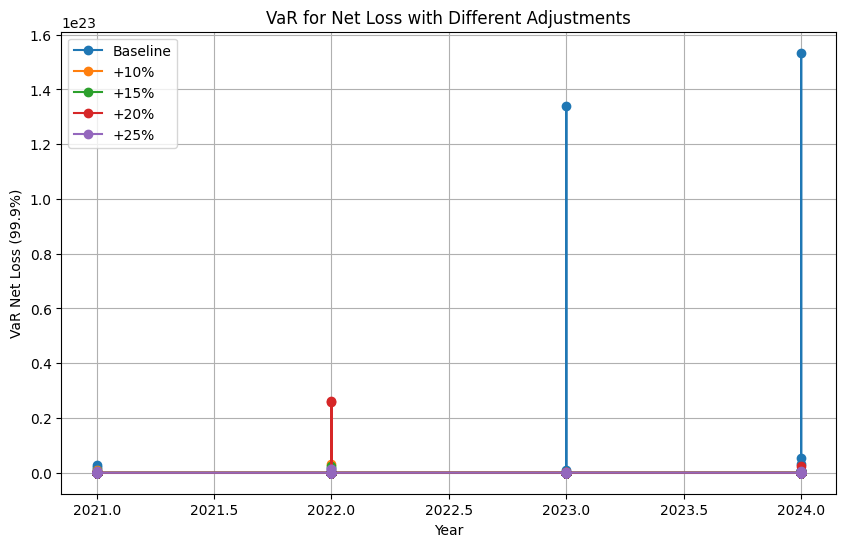

In [39]:
import matplotlib.pyplot as plt

# Example: Plotting VaR for Net Loss for each adjustment type
plt.figure(figsize=(10, 6))
plt.plot(baseline_df['Year'], baseline_df['VaR Net Loss (99.9%)'], label='Baseline', marker='o')
plt.plot(plus_10_df['Year'], plus_10_df['VaR Net Loss (99.9%)'], label='+10%', marker='o')
plt.plot(plus_15_df['Year'], plus_15_df['VaR Net Loss (99.9%)'], label='+15%', marker='o')
plt.plot(plus_20_df['Year'], plus_20_df['VaR Net Loss (99.9%)'], label='+20%', marker='o')
plt.plot(plus_25_df['Year'], plus_25_df['VaR Net Loss (99.9%)'], label='+25%', marker='o')

plt.xlabel('Year')
plt.ylabel('VaR Net Loss (99.9%)')
plt.title('VaR for Net Loss with Different Adjustments')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
#prediction for 2025 averaghe net loss

from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Aggregate data from 2021–2024 for each business line and event type
for business_line in df['Business Line'].unique():
    for event_type in df['Event Type'].unique():
        # Filter data for the specific business line and event type across 2021–2024
        aggregated_data = df[
            (df['Year'].isin(range(2021, 2025))) &
            (df['Business Line'] == business_line) &
            (df['Event Type'] == event_type)
        ]
        
        # Total event counts and net loss
        total_event_count = aggregated_data.shape[0]
        total_net_loss = aggregated_data['Net Loss Amount'].sum()
        
        if total_event_count == 0:
            print(f"No data for {business_line} - {event_type} from 2021–2024. Skipping.")
            continue
        
        # Frequency parameter (Poisson λ)
        frequency_lambda = total_event_count / 4  # Average events per year
        
        # Severity parameters (Log-Normal distribution)
        positive_losses = aggregated_data[aggregated_data['Net Loss Amount'] > 0]['Net Loss Amount']
        if positive_losses.empty:
            print(f"No positive losses for {business_line} - {event_type} from 2021–2024. Skipping.")
            continue
        severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
        
        # Calculate VaR for Net Loss
        var_net_loss = calculate_net_loss_var(
            frequency_lambda=frequency_lambda,
            severity_shape=severity_shape,
            severity_scale=severity_scale,
            severity_loc=severity_loc,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Calculate VaR for Event Count
        var_event_count = calculate_event_count_var(
            frequency_lambda=frequency_lambda,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Append results
        results.append({
            'Prediction Year': 2025,
            'Business Line': business_line,
            'Event Type': event_type,
            'Average Net Loss (2021–2024)': total_net_loss / 4,
            'Average Event Count (2021–2024)': frequency_lambda,
            'VaR Net Loss (99.9%)': var_net_loss,
            'VaR Event Count (99.9%)': var_event_count
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Prediction Year      Business Line            Event Type  \
0              2025  Corporate Banking            Compliance   
1              2025  Corporate Banking           Vendor Risk   
2              2025  Corporate Banking                 Theft   
3              2025  Corporate Banking     Operational Error   
4              2025  Corporate Banking        System Failure   
..              ...                ...                   ...   
95             2025          Insurance           Market Risk   
96             2025          Insurance          Cyber Attack   
97             2025          Insurance      Natural Disaster   
98             2025          Insurance  Regulatory Violation   
99             2025          Insurance                 Fraud   

    Average Net Loss (2021–2024)  Average Event Count (2021–2024)  \
0                  -44511.931610                            25.50   
1                  -13183.467978                            24.00   
2                   2232

In [41]:
results_df

,Prediction Year,Business Line,Event Type,Average Net Loss (2021–2024),Average Event Count (2021–2024),VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2025,Corporate Banking,Compliance,-44511.931610,25.50,695007.775559,43.000
1,2025,Corporate Banking,Vendor Risk,-13183.467978,24.00,447640.372266,40.000
2,2025,Corporate Banking,Theft,22323.587859,25.50,444627.070528,43.000
3,2025,Corporate Banking,Operational Error,26282.011363,24.50,438395.255764,41.000
4,2025,Corporate Banking,System Failure,-4787.022903,24.00,382622.450158,40.000
...,...,...,...,...,...,...,...
95,2025,Insurance,Market Risk,-17561.154709,24.25,415852.332242,41.000
96,2025,Insurance,Cyber Attack,15736.879016,22.00,349344.587372,38.000
97,2025,Insurance,Natural Disaster,-17518.441928,29.75,513172.716937,48.000
98,2025,Insurance,Regulatory Violation,-17430.764354,25.25,531351.502726,42.001


In [42]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Aggregate data from 2021–2024 for each business line and event type
for business_line in df['Business Line'].unique():
    for event_type in df['Event Type'].unique():
        # Filter data for the specific business line and event type across 2021–2024
        aggregated_data = df[
            (df['Year'].isin(range(2021, 2025))) &
            (df['Business Line'] == business_line) &
            (df['Event Type'] == event_type)
        ]
        
        # Total event counts and net loss
        total_event_count = aggregated_data.shape[0]
        total_net_loss = aggregated_data['Net Loss Amount'].sum()
        
        if total_event_count == 0:
            print(f"No data for {business_line} - {event_type} from 2021–2024. Skipping.")
            continue
        
        # Frequency parameter (Poisson λ)
        frequency_lambda = total_event_count / 4  # Average events per year
        
        # Severity parameters (Log-Normal distribution)
        positive_losses = aggregated_data[aggregated_data['Net Loss Amount'] > 0]['Net Loss Amount']
        if positive_losses.empty:
            print(f"No positive losses for {business_line} - {event_type} from 2021–2024. Skipping.")
            continue
        severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
        
        # Calculate VaR for Net Loss
        var_net_loss = calculate_net_loss_var(
            frequency_lambda=frequency_lambda,
            severity_shape=severity_shape,
            severity_scale=severity_scale,
            severity_loc=severity_loc,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Calculate VaR for Event Count
        var_event_count = calculate_event_count_var(
            frequency_lambda=frequency_lambda,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Average net loss and event count over 2021-2024 (per quarter)
        avg_net_loss_per_year = total_net_loss / 4
        avg_net_loss_per_quarter = avg_net_loss_per_year / 4
        
        # Append results for 2025 prediction (split quarterly)
        for quarter in range(1, 5):
            results.append({
                'Prediction Year': 2025,
                'Quarter': quarter,
                'Business Line': business_line,
                'Event Type': event_type,
                'Average Net Loss (2021–2024)': avg_net_loss_per_year,
                'Average Net Loss per Quarter (2025)': avg_net_loss_per_quarter,
                'Average Event Count (2021–2024)': frequency_lambda,
                'VaR Net Loss (99.9%)': var_net_loss,
                'VaR Event Count (99.9%)': var_event_count
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Prediction Year  Quarter      Business Line            Event Type  \
0               2025        1  Corporate Banking            Compliance   
1               2025        2  Corporate Banking            Compliance   
2               2025        3  Corporate Banking            Compliance   
3               2025        4  Corporate Banking            Compliance   
4               2025        1  Corporate Banking           Vendor Risk   
..               ...      ...                ...                   ...   
395             2025        4          Insurance  Regulatory Violation   
396             2025        1          Insurance                 Fraud   
397             2025        2          Insurance                 Fraud   
398             2025        3          Insurance                 Fraud   
399             2025        4          Insurance                 Fraud   

     Average Net Loss (2021–2024)  Average Net Loss per Quarter (2025)  \
0                   -44511.931610    

In [43]:
results_df

,Prediction Year,Quarter,Business Line,Event Type,Average Net Loss (2021–2024),Average Net Loss per Quarter (2025),Average Event Count (2021–2024),VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2025,1,Corporate Banking,Compliance,-44511.931610,-11127.982903,25.50,697095.905644,42.0
1,2025,2,Corporate Banking,Compliance,-44511.931610,-11127.982903,25.50,697095.905644,42.0
2,2025,3,Corporate Banking,Compliance,-44511.931610,-11127.982903,25.50,697095.905644,42.0
3,2025,4,Corporate Banking,Compliance,-44511.931610,-11127.982903,25.50,697095.905644,42.0
4,2025,1,Corporate Banking,Vendor Risk,-13183.467978,-3295.866995,24.00,471494.662889,40.0
...,...,...,...,...,...,...,...,...,...
395,2025,4,Insurance,Regulatory Violation,-17430.764354,-4357.691088,25.25,531337.996644,41.0
396,2025,1,Insurance,Fraud,-25851.489306,-6462.872327,25.50,441879.098689,43.0
397,2025,2,Insurance,Fraud,-25851.489306,-6462.872327,25.50,441879.098689,43.0
398,2025,3,Insurance,Fraud,-25851.489306,-6462.872327,25.50,441879.098689,43.0


In [44]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Aggregate data for 2024 only for each business line and event type
for business_line in df['Business Line'].unique():
    for event_type in df['Event Type'].unique():
        # Filter data for the specific business line and event type in 2024 only
        aggregated_data = df[
            (df['Year'] == 2024) &  # Filter for 2024 only
            (df['Business Line'] == business_line) &
            (df['Event Type'] == event_type)
        ]
        
        # Total event counts and net loss
        total_event_count = aggregated_data.shape[0]
        total_net_loss = aggregated_data['Net Loss Amount'].sum()
        
        if total_event_count == 0:
            print(f"No data for {business_line} - {event_type} in 2024. Skipping.")
            continue
        
        # Frequency parameter (Poisson λ)
        frequency_lambda = total_event_count / 1  # Events per year (for 2024)
        
        # Severity parameters (Log-Normal distribution)
        positive_losses = aggregated_data[aggregated_data['Net Loss Amount'] > 0]['Net Loss Amount']
        if positive_losses.empty:
            print(f"No positive losses for {business_line} - {event_type} in 2024. Skipping.")
            continue
        severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
        
        # Calculate VaR for Net Loss
        var_net_loss = calculate_net_loss_var(
            frequency_lambda=frequency_lambda,
            severity_shape=severity_shape,
            severity_scale=severity_scale,
            severity_loc=severity_loc,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Calculate VaR for Event Count
        var_event_count = calculate_event_count_var(
            frequency_lambda=frequency_lambda,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Append results
        results.append({
            'Prediction Year': 2025,
            'Business Line': business_line,
            'Event Type': event_type,
            'Average Net Loss (2024)': total_net_loss / total_event_count if total_event_count > 0 else 0,  # Average net loss per event in 2024
            'Average Event Count (2024)': frequency_lambda,
            'VaR Net Loss (99.9%)': var_net_loss,
            'VaR Event Count (99.9%)': var_event_count
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Prediction Year      Business Line            Event Type  \
0              2025  Corporate Banking            Compliance   
1              2025  Corporate Banking           Vendor Risk   
2              2025  Corporate Banking                 Theft   
3              2025  Corporate Banking     Operational Error   
4              2025  Corporate Banking        System Failure   
..              ...                ...                   ...   
95             2025          Insurance           Market Risk   
96             2025          Insurance          Cyber Attack   
97             2025          Insurance      Natural Disaster   
98             2025          Insurance  Regulatory Violation   
99             2025          Insurance                 Fraud   

    Average Net Loss (2024)  Average Event Count (2024)  VaR Net Loss (99.9%)  \
0              -1315.976310                        26.0          1.887545e+19   
1              -1876.642819                        24.0          4.31

In [45]:
results_df

,Prediction Year,Business Line,Event Type,Average Net Loss (2024),Average Event Count (2024),VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2025,Corporate Banking,Compliance,-1315.976310,26.0,1.887545e+19,43.000
1,2025,Corporate Banking,Vendor Risk,-1876.642819,24.0,4.314433e+21,41.000
2,2025,Corporate Banking,Theft,118.751870,21.0,1.923031e+17,37.000
3,2025,Corporate Banking,Operational Error,680.409930,23.0,1.119059e+18,39.000
4,2025,Corporate Banking,System Failure,-2614.855157,23.0,2.295444e+19,39.000
...,...,...,...,...,...,...,...
95,2025,Insurance,Market Risk,107.488272,25.0,8.634402e+17,43.000
96,2025,Insurance,Cyber Attack,3064.219908,12.0,3.243897e+17,24.000
97,2025,Insurance,Natural Disaster,-1205.117303,31.0,9.435768e+18,48.002
98,2025,Insurance,Regulatory Violation,353.053263,23.0,1.823705e+19,40.000


In [55]:
# from scipy.stats import poisson, lognorm
# import pandas as pd
# import numpy as np

# # Function to calculate VaR for Net Loss using Monte Carlo
# def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
#     simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
#     simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
#     total_losses = simulated_event_counts * simulated_loss_amounts
#     var_value = np.percentile(total_losses, confidence_level * 100)
#     return var_value

# # Function to calculate VaR for Event Counts using Monte Carlo
# def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
#     simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
#     var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
#     return var_event_count

# # Prepare results
# results = []

# # Define confidence level and number of simulations
# confidence_level = 0.999
# n_simulations = 10000

# # Add a 'Quarter' column to group by quarter (Q1, Q2, Q3, Q4) in 2024
# df['Quarter'] = pd.to_datetime(df['Date']).dt.to_period('Q')

# # Aggregate data for each quarter of 2024 for each business line and event type
# for business_line in df['Business Line'].unique():
#     for event_type in df['Event Type'].unique():
#         for quarter in pd.period_range('2024Q1', '2024Q4'):
#             # Filter data for the specific business line, event type, and quarter in 2024
#             aggregated_data = df[
#                 (df['Year'] == 2024) &
#                 (df['Business Line'] == business_line) &
#                 (df['Event Type'] == event_type) &
#                 (df['Quarter'] == quarter)
#             ]
            
#             # Total event counts and net loss
#             total_event_count = aggregated_data.shape[0]
#             total_net_loss = aggregated_data['Net Loss Amount'].sum()
            
#             if total_event_count == 0:
#                 print(f"No data for {business_line} - {event_type} in {quarter}. Skipping.")
#                 continue
            
#             # Frequency parameter (Poisson λ)
#             frequency_lambda = total_event_count / 1  # Events per quarter (for 2024)
            
#             # Severity parameters (Log-Normal distribution)
#             positive_losses = aggregated_data[aggregated_data['Net Loss Amount'] > 0]['Net Loss Amount']
#             if positive_losses.empty:
#                 print(f"No positive losses for {business_line} - {event_type} in {quarter}. Skipping.")
#                 continue
#             severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
#             # Calculate VaR for Net Loss
#             var_net_loss = calculate_net_loss_var(
#                 frequency_lambda=frequency_lambda,
#                 severity_shape=severity_shape,
#                 severity_scale=severity_scale,
#                 severity_loc=severity_loc,
#                 confidence_level=confidence_level,
#                 n_simulations=n_simulations
#             )
            
#             # Calculate VaR for Event Count
#             var_event_count = calculate_event_count_var(
#                 frequency_lambda=frequency_lambda,
#                 confidence_level=confidence_level,
#                 n_simulations=n_simulations
#             )
            
#             # Append results
#             results.append({
#                 'Prediction Year': 2025,
#                 'Quarter': quarter,
#                 'Business Line': business_line,
#                 'Event Type': event_type,
#                 'Average Net Loss (2024)': total_net_loss / total_event_count if total_event_count > 0 else 0,  # Average net loss per event in 2024
#                 'Average Event Count (2024)': frequency_lambda,
#                 'VaR Net Loss (99.9%)': var_net_loss,
#                 'VaR Event Count (99.9%)': var_event_count
#             })

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Display results
# print(results_df)


In [47]:
results_df

""
